# Diamonds - regression classification

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import mplcatppuccin
import matplotlib as mpl

mpl.style.use('mocha')
pd.options.display.max_columns = 500

## Load the diamonds dataset in a dataframe called 'diamonds'

In [2]:
diamonds = pd.read_csv('diamonds.csv')
diamonds.head()

carat         cut color clarity  depth  table  price   'x'   'y'   'z'
0   0.23    b'Ideal'  b'E'  b'SI2'   61.5   55.0  326.0  3.95  3.98  2.43
1   0.21  b'Premium'  b'E'  b'SI1'   59.8   61.0  326.0  3.89  3.84  2.31
2   0.23     b'Good'  b'E'  b'VS1'   56.9   65.0  327.0  4.05  4.07  2.31
3   0.29  b'Premium'  b'I'  b'VS2'   62.4   58.0  334.0  4.20  4.23  2.63
4   0.31     b'Good'  b'J'  b'SI2'   63.3   58.0  335.0  4.34  4.35  2.75

## Clean the data of duplicates, if any

In [3]:
diamonds.duplicated().any()

True

In [4]:
diamonds.shape

(53940, 10)

In [5]:
diamonds = diamonds.drop_duplicates()
diamonds.shape

(53794, 10)

### The document mentions to check for duplicated values in the subset of features below

In [6]:
dup_cols = ['carat', 'cut', 'color', 'clarity', 'price']
diamonds = diamonds.drop_duplicates(subset=dup_cols)
diamonds.shape

(39756, 10)

## EDA

In [7]:
diamonds.head()

carat         cut color clarity  depth  table  price   'x'   'y'   'z'
0   0.23    b'Ideal'  b'E'  b'SI2'   61.5   55.0  326.0  3.95  3.98  2.43
1   0.21  b'Premium'  b'E'  b'SI1'   59.8   61.0  326.0  3.89  3.84  2.31
2   0.23     b'Good'  b'E'  b'VS1'   56.9   65.0  327.0  4.05  4.07  2.31
3   0.29  b'Premium'  b'I'  b'VS2'   62.4   58.0  334.0  4.20  4.23  2.63
4   0.31     b'Good'  b'J'  b'SI2'   63.3   58.0  335.0  4.34  4.35  2.75

### Let's rename the columns x, y and z for easier access

In [8]:
diamonds = diamonds.rename(columns={"'x'":'x', "'y'":'y', "'z'":'z'})
diamonds.head()

carat         cut color clarity  depth  table  price     x     y     z
0   0.23    b'Ideal'  b'E'  b'SI2'   61.5   55.0  326.0  3.95  3.98  2.43
1   0.21  b'Premium'  b'E'  b'SI1'   59.8   61.0  326.0  3.89  3.84  2.31
2   0.23     b'Good'  b'E'  b'VS1'   56.9   65.0  327.0  4.05  4.07  2.31
3   0.29  b'Premium'  b'I'  b'VS2'   62.4   58.0  334.0  4.20  4.23  2.63
4   0.31     b'Good'  b'J'  b'SI2'   63.3   58.0  335.0  4.34  4.35  2.75

### It can be seen some 'b' values in cut, color and clarity... If needed, let's remove those for reading the values easier

In [9]:
diamonds['cut'] = diamonds['cut'].str.extract(pat="\'(\w+)")
diamonds['color'] = diamonds['color'].str.extract(pat="\'(\w+)")
diamonds['clarity'] = diamonds['clarity'].str.extract(pat="\'(\w+)")
diamonds.head()

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0  326.0  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0  326.0  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0  327.0  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0  334.0  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0  335.0  4.34  4.35  2.75

### Understanding the features... what are we talking about?

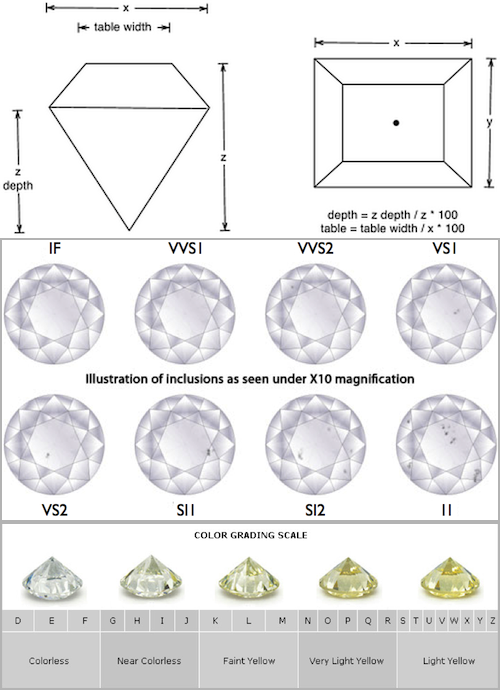

In [10]:
from PIL import Image

a = Image.open('diamonds_measures.png')
b = Image.open('diamonds_clarity.png')
c = Image.open('diamonds_colors.png')

Image.fromarray(np.vstack((np.array(a), np.array(b), np.array(c))))

### So... if you want to propose... you already know what to look for. On the other side, if you have received the proposal ring... well... now you know how to determine the diamond's quality :)

### Jokes aside, the first picture shows how the diamonds are measured... perhaps would be a good idea to add the two additional measures missing (z-depth and table_width)

### The second picture shows the grading of the diamonds depending on the clarity of the diamonds, therefore the more impurities the diamond has, the lower the clarity grade

### And last but not least, the color is graded with a letter depending on the whiteness of the piece. The whiter, the better (guess it's kind of obvious? :P)

### Let's add the missing measurements and rearrange a bit the data

In [11]:
diamonds['z_depth'] = np.round((diamonds['z']*diamonds['depth'])/100,2)
diamonds['table_width'] = np.round((diamonds['table']*diamonds['x'])/100,2)

numeric_feats = [ 'price', 'carat', 'x', 'table_width', 'table', 'y', 'z', 'z_depth', 'depth']
nums = diamonds[numeric_feats]
diamonds = diamonds.drop(numeric_feats, axis=1)
diamonds = pd.concat([diamonds, nums], axis=1)
diamonds.head()

cut color clarity  price  carat     x  table_width  table     y     z  \
0    Ideal     E     SI2  326.0   0.23  3.95         2.17   55.0  3.98  2.43   
1  Premium     E     SI1  326.0   0.21  3.89         2.37   61.0  3.84  2.31   
2     Good     E     VS1  327.0   0.23  4.05         2.63   65.0  4.07  2.31   
3  Premium     I     VS2  334.0   0.29  4.20         2.44   58.0  4.23  2.63   
4     Good     J     SI2  335.0   0.31  4.34         2.52   58.0  4.35  2.75   

   z_depth  depth  
0     1.49   61.5  
1     1.38   59.8  
2     1.31   56.9  
3     1.64   62.4  
4     1.74   63.3

In [12]:
diamonds.describe().T

count         mean          std    min      25%      50%  \
price        39756.0  4688.161384  4201.617572  326.0  1410.00  3369.00   
carat        39756.0     0.903571     0.479221    0.2     0.52     0.85   
x            39756.0     6.007941     1.082521    0.0     5.16     6.04   
table_width  39756.0     3.463230     0.660945    0.0     2.93     3.49   
table        39756.0    57.575634     2.298224   43.0    56.00    57.00   
y            39756.0     6.011052     1.105099    0.0     5.17     6.04   
z            39756.0     3.709011     0.687200    0.0     3.19     3.73   
z_depth      39756.0     2.291159     0.434903    0.0     1.96     2.30   
depth        39756.0    61.740281     1.533119   43.0    61.00    61.80   

                 75%       max  
price        6409.25  18823.00  
carat           1.15      5.01  
x               6.73     10.74  
table_width     3.90      7.90  
table          59.00     95.00  
y               6.72     58.90  
z               4.15     31.80  
z_depth         2.58     19.65  
depth          62.60     79.00

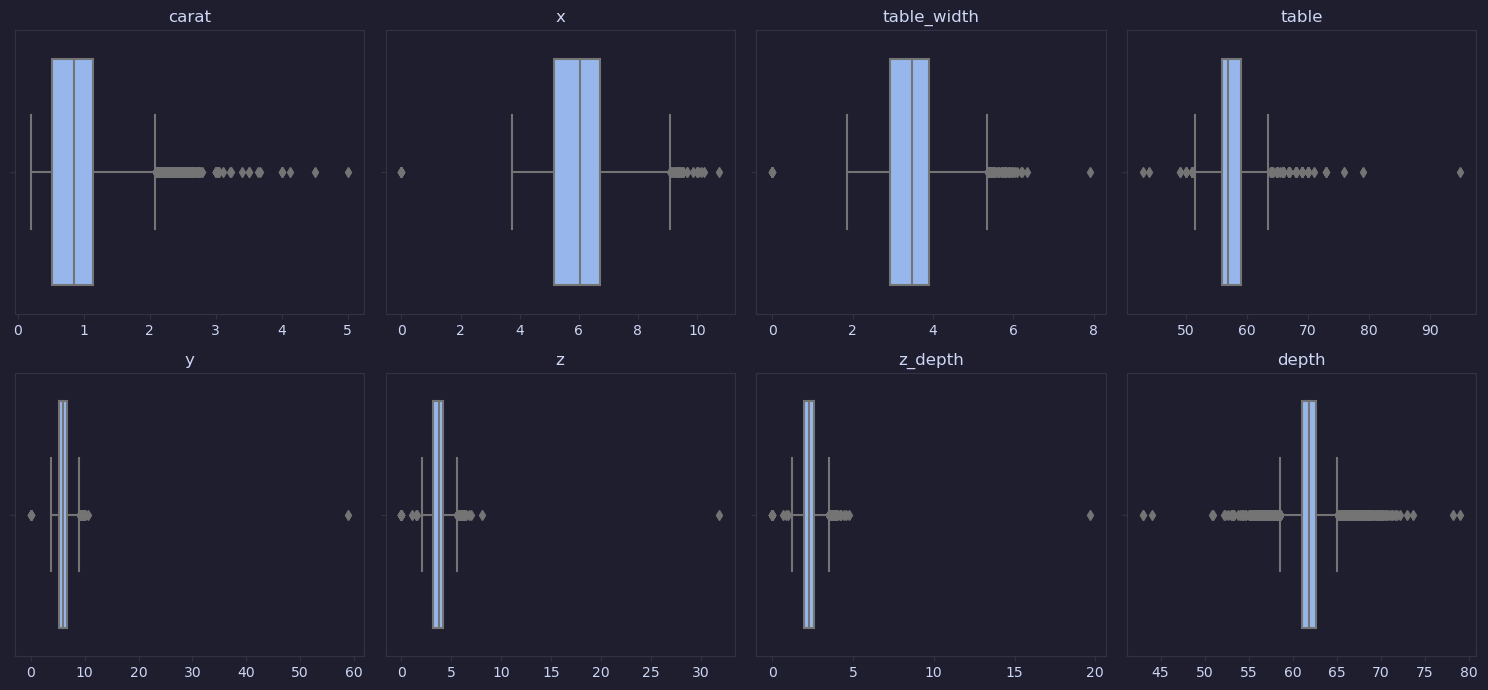

In [13]:
nrows = 2
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))

a = 4
for i in range(nrows):
  for j in range(ncols):
    sns.boxplot(data=diamonds, x=diamonds.columns[a], ax=axs[i,j])
    axs[i,j].set_title(diamonds.columns[a])
    axs[i,j].set_xlabel('')
    a+=1

plt.tight_layout()

### So... when checking the stats of the numeric values, as well as the boxplots, it is not possible to have measuremtns of 0, so we need to drop those values, otherwise they might corrupt the data

In [14]:
diamonds = diamonds.loc[(diamonds['x']>0) & (diamonds['y']>0) & (diamonds['z']>0)]
diamonds.head()

cut color clarity  price  carat     x  table_width  table     y     z  \
0    Ideal     E     SI2  326.0   0.23  3.95         2.17   55.0  3.98  2.43   
1  Premium     E     SI1  326.0   0.21  3.89         2.37   61.0  3.84  2.31   
2     Good     E     VS1  327.0   0.23  4.05         2.63   65.0  4.07  2.31   
3  Premium     I     VS2  334.0   0.29  4.20         2.44   58.0  4.23  2.63   
4     Good     J     SI2  335.0   0.31  4.34         2.52   58.0  4.35  2.75   

   z_depth  depth  
0     1.49   61.5  
1     1.38   59.8  
2     1.31   56.9  
3     1.64   62.4  
4     1.74   63.3

In [15]:
diamonds.describe().T

count         mean          std     min      25%       50%  \
price        39738.0  4686.366173  4199.807885  326.00  1410.00  3365.500   
carat        39738.0     0.903319     0.479021    0.20     0.52     0.850   
x            39738.0     6.008617     1.079472    3.73     5.16     6.040   
table_width  39738.0     3.463595     0.659264    1.85     2.93     3.490   
table        39738.0    57.575165     2.297805   43.00    56.00    57.000   
y            39738.0     6.011579     1.102549    3.68     5.17     6.040   
z            39738.0     3.710692     0.682806    1.07     3.19     3.735   
z_depth      39738.0     2.292197     0.432258    0.65     1.96     2.300   
depth        39738.0    61.740508     1.532816   43.00    61.00    61.800   

                 75%       max  
price        6406.75  18823.00  
carat           1.15      5.01  
x               6.73     10.74  
table_width     3.90      7.90  
table          59.00     95.00  
y               6.72     58.90  
z               4.15     31.80  
z_depth         2.58     19.65  
depth          62.60     79.00

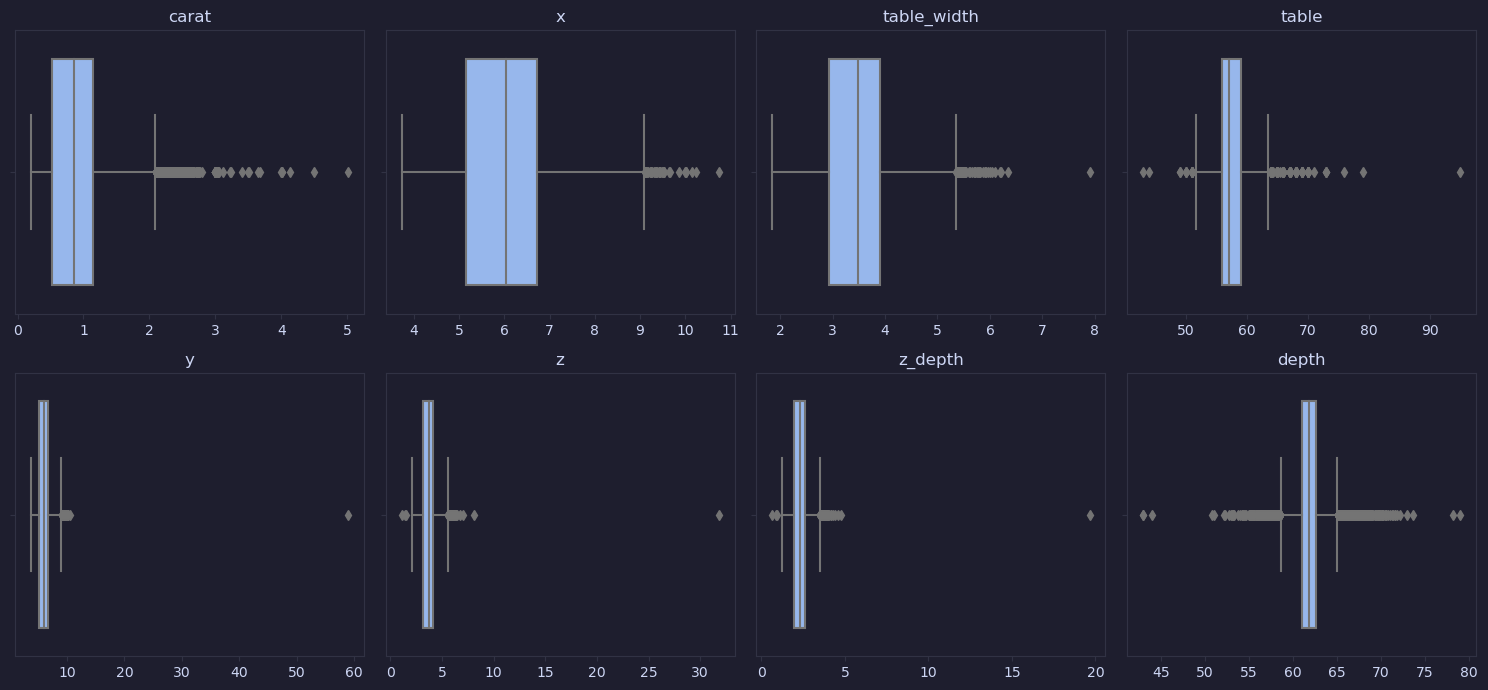

In [16]:
nrows = 2
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))

a = 4
for i in range(nrows):
  for j in range(ncols):
    sns.boxplot(data=diamonds, x=diamonds.columns[a], ax=axs[i,j])
    axs[i,j].set_title(diamonds.columns[a])
    axs[i,j].set_xlabel('')
    a+=1

plt.tight_layout()

### There are still a couple of VERY outliers in both y and z features. It is important to remove them as those could skew the data (and actually would be VERY large diamonds)

In [17]:
diamonds = diamonds.loc[(diamonds['y']<50) & (diamonds['z']<30)]
diamonds.head()

cut color clarity  price  carat     x  table_width  table     y     z  \
0    Ideal     E     SI2  326.0   0.23  3.95         2.17   55.0  3.98  2.43   
1  Premium     E     SI1  326.0   0.21  3.89         2.37   61.0  3.84  2.31   
2     Good     E     VS1  327.0   0.23  4.05         2.63   65.0  4.07  2.31   
3  Premium     I     VS2  334.0   0.29  4.20         2.44   58.0  4.23  2.63   
4     Good     J     SI2  335.0   0.31  4.34         2.52   58.0  4.35  2.75   

   z_depth  depth  
0     1.49   61.5  
1     1.38   59.8  
2     1.31   56.9  
3     1.64   62.4  
4     1.74   63.3

In [18]:
diamonds.describe().T

count         mean          std     min      25%      50%  \
price        39736.0  4686.245193  4199.721871  326.00  1410.00  3365.50   
carat        39736.0     0.903302     0.478998    0.20     0.52     0.85   
x            39736.0     6.008587     1.079439    3.73     5.16     6.04   
table_width  39736.0     3.463583     0.659247    1.85     2.93     3.49   
table        39736.0    57.575252     2.297816   43.00    56.00    57.00   
y            39736.0     6.010270     1.070167    3.68     5.17     6.04   
z            39736.0     3.709875     0.667768    1.07     3.19     3.73   
z_depth      39736.0     2.291698     0.423228    0.65     1.96     2.30   
depth        39736.0    61.740578     1.532788   43.00    61.00    61.80   

                 75%       max  
price        6406.25  18823.00  
carat           1.15      5.01  
x               6.73     10.74  
table_width     3.90      7.90  
table          59.00     95.00  
y               6.72     10.54  
z               4.15      6.98  
z_depth         2.58      4.57  
depth          62.60     79.00

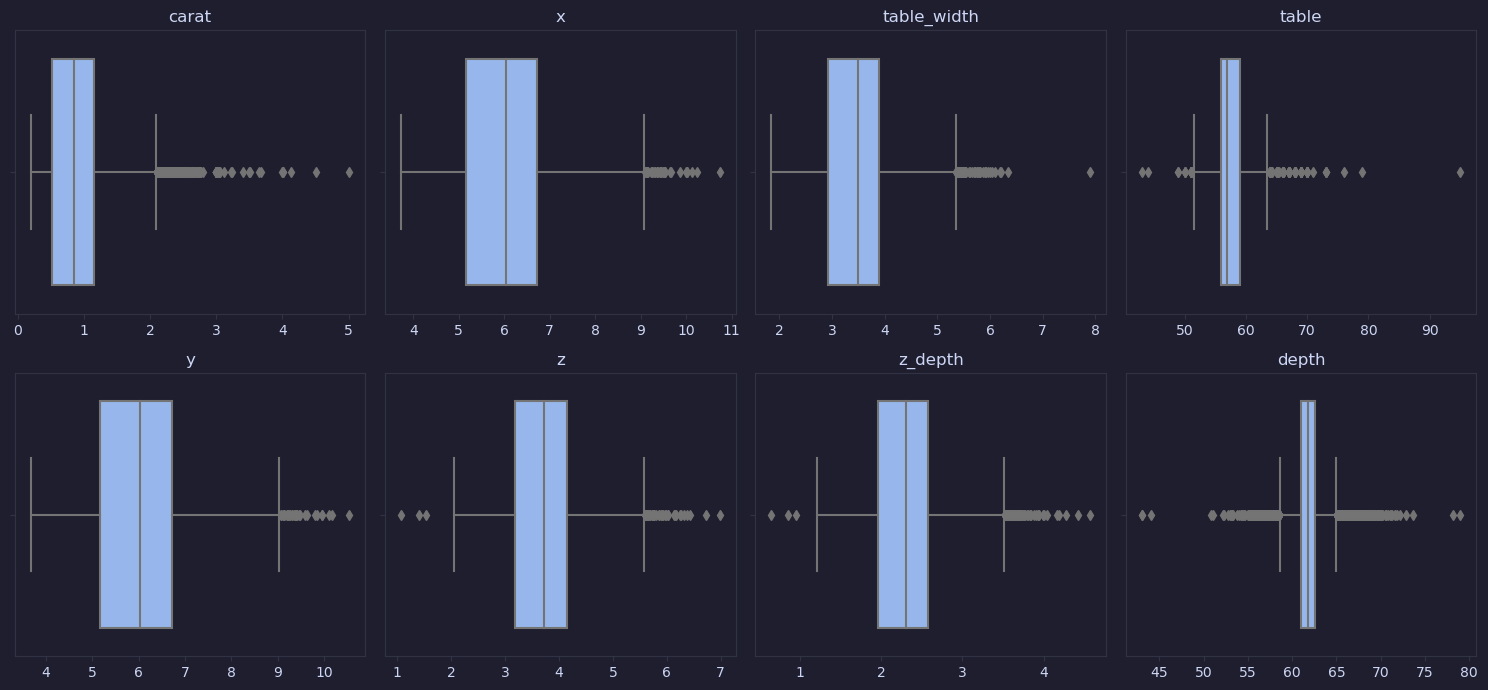

In [19]:
nrows = 2
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))

a = 4
for i in range(nrows):
  for j in range(ncols):
    sns.boxplot(data=diamonds, x=diamonds.columns[a], ax=axs[i,j])
    axs[i,j].set_title(diamonds.columns[a])
    axs[i,j].set_xlabel('')
    a+=1

plt.tight_layout()

### Checking the interaction of the numeric features vs the price

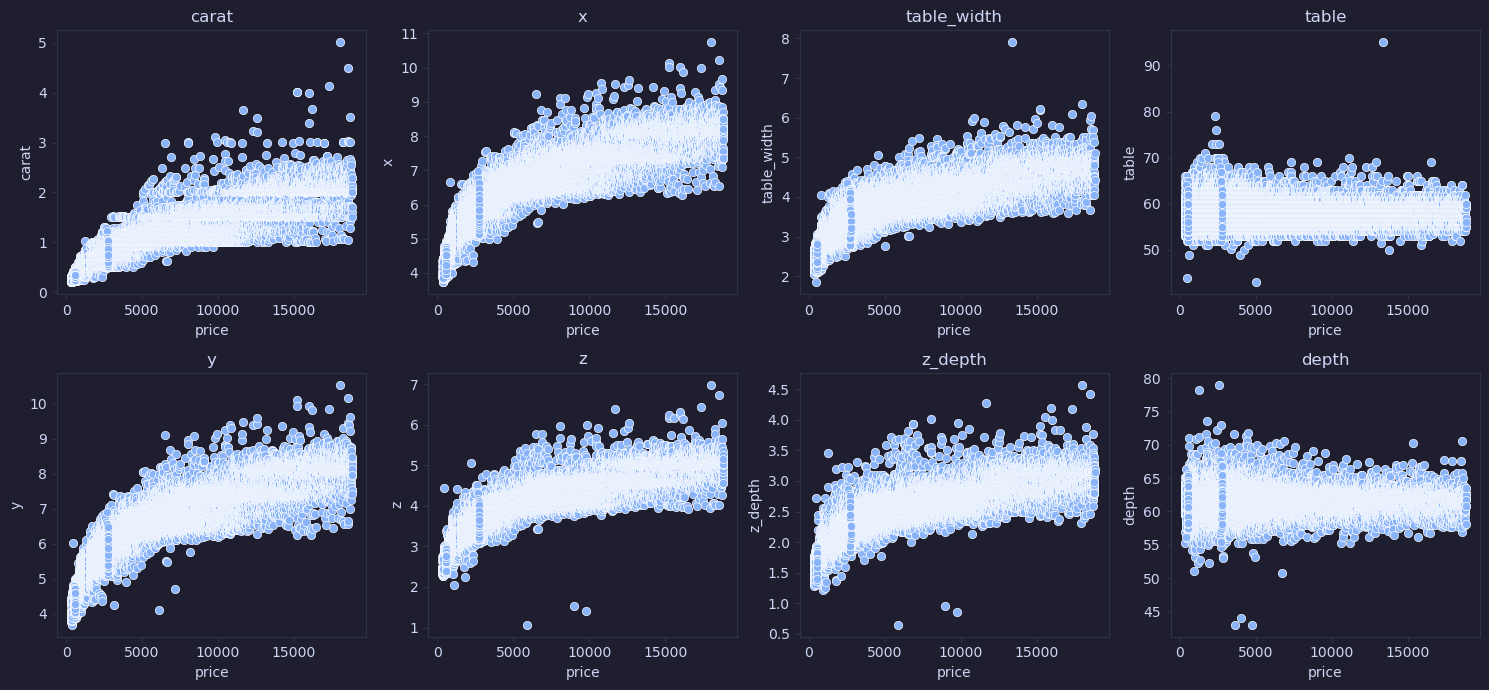

In [20]:
nrows = 2 ### Número de filas en el grid
ncols = 4 ### Número de columnas en el grid

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7)) ### Se crea el grid

a = 4 ### Esta variable ayudará en iterar sobre las columnas
for i in range(nrows): ### Loop para iterar sobre las filas
  for j in range(ncols): ### Loop para iterar sobre las columnas

    ### Función de seaborn para graficar la variable precio (diamonds.columns[3]) sobre la iteración de las demás variables (diamonds.columns[a]). La iteración sobre el grid se hace en el parámetro ax=axs[i,j]

    sns.scatterplot(data=diamonds, x=diamonds.columns[3], y=diamonds.columns[a], ax=axs[i,j])

    axs[i,j].set_title(diamonds.columns[a]) ### Se muestra el título de cada tabla utilizando el nombre de la columna

    a+=1 ### a+=1 aumenta la variable 'a' en 1 para que "salte" a la siguiente columna en la función de seaborn

plt.tight_layout()

<AxesSubplot: >

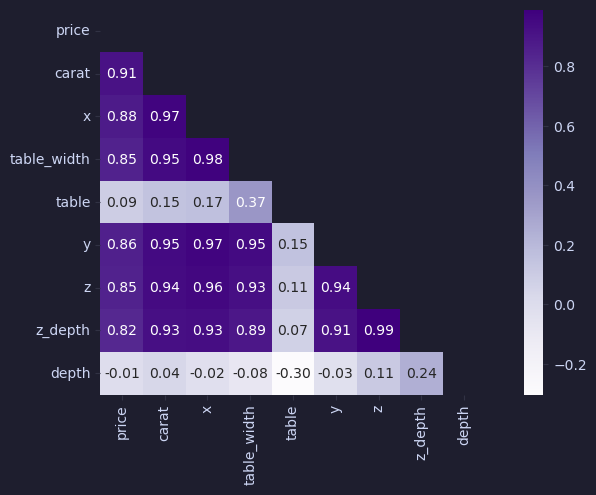

In [21]:
plt.figure(figsize=(10,5))
corr = nums.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(data=corr, annot=True, fmt='0.2f', cmap='Purples', annot_kws={'size':10}, square=True, mask=mask)


In [22]:
corr = corr.apply(lambda x: np.round(x,2))
corr['price']

price          1.00
carat          0.91
x              0.88
table_width    0.85
table          0.09
y              0.86
z              0.85
z_depth        0.82
depth         -0.01
Name: price, dtype: float64

### So a lot of direct correlation between price and other features. Only depth and table are not so strong. Let's check for colinearity

In [23]:
corr_col = nums.drop('price', axis=1).corr()
corr_col

carat         x  table_width     table         y         z  \
carat        1.000000  0.973093     0.950147  0.150066  0.946683  0.942958   
x            0.973093  1.000000     0.977790  0.165493  0.970963  0.960175   
table_width  0.950147  0.977790     1.000000  0.365051  0.947833  0.928792   
table        0.150066  0.165493     0.365051  1.000000  0.153498  0.113284   
y            0.946683  0.970963     0.947833  0.153498  1.000000  0.938680   
z            0.942958  0.960175     0.928792  0.113284  0.938680  1.000000   
z_depth      0.925201  0.933547     0.894604  0.072060  0.911516  0.990812   
depth        0.037128 -0.021797    -0.084990 -0.302658 -0.026984  0.113158   

              z_depth     depth  
carat        0.925201  0.037128  
x            0.933547 -0.021797  
table_width  0.894604 -0.084990  
table        0.072060 -0.302658  
y            0.911516 -0.026984  
z            0.990812  0.113158  
z_depth      1.000000  0.244167  
depth        0.244167  1.000000

<AxesSubplot: >

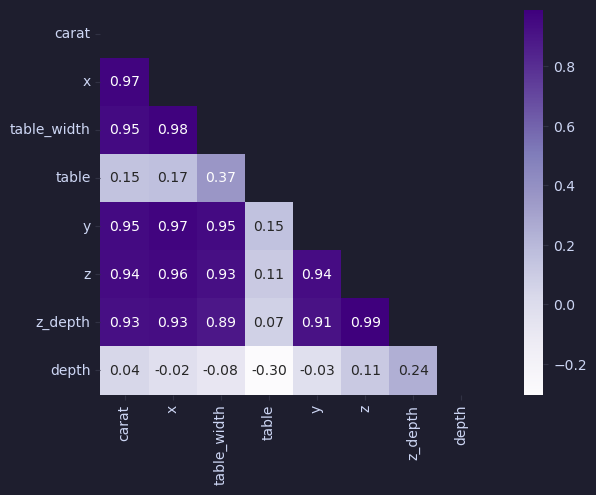

In [24]:
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(corr_col))
sns.heatmap(data=corr_col, annot=True, fmt='0.2f', cmap='Purples', annot_kws={'size':10}, square=True, mask=mask)

### There is some risk of colinearity. Although it is kind of expected as a lot of features have relation between them. Let's move forward with the 'categorical' features

In [25]:
categories = diamonds[['cut', 'color', 'clarity', 'price']]

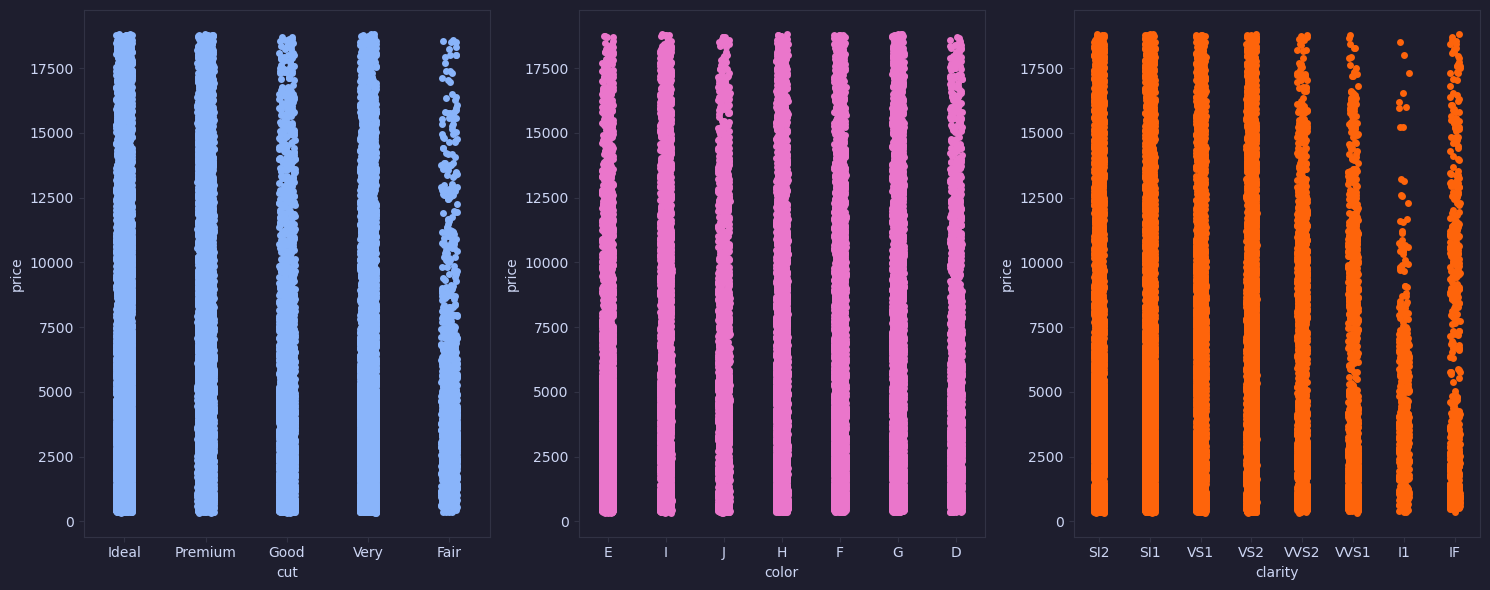

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
sns.stripplot(data=categories, x='cut', y='price', ax=axs[0])
sns.stripplot(data=categories, x='color', y='price', color='#EA76CB', ax=axs[1])
sns.stripplot(data=categories, x='clarity', y='price', color='#FE640B', ax=axs[2])
plt.tight_layout()

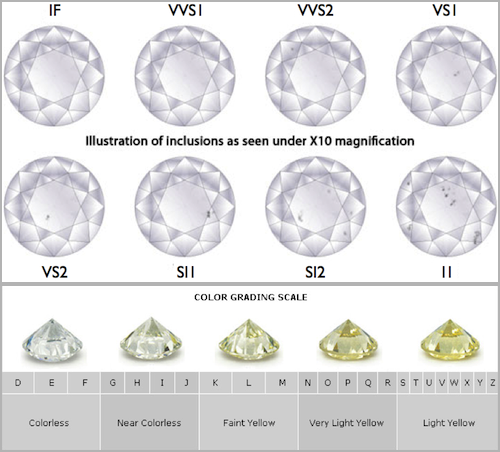

In [27]:
from PIL import Image

b = Image.open('diamonds_clarity.png')
c = Image.open('diamonds_colors.png')

Image.fromarray(np.vstack((np.array(b), np.array(c))))

In [28]:
cut_map = {'Ideal':5, 'Premium':4, 'Good':3, 'Very':2, 'Fair':1}
color_map = {'D':7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1}
clarity_map = {'IF':8, 'VVS1':7, 'VVS2':6, 'VS1':5, 'VS2':4, 'SI1':3, 'SI2':2, 'I1':1}

diamonds['cut'] = diamonds['cut'].map(cut_map)
diamonds['color'] = diamonds['color'].map(color_map)
diamonds['clarity'] = diamonds['clarity'].map(clarity_map)

In [29]:
diamonds.isna().sum().sum()

0

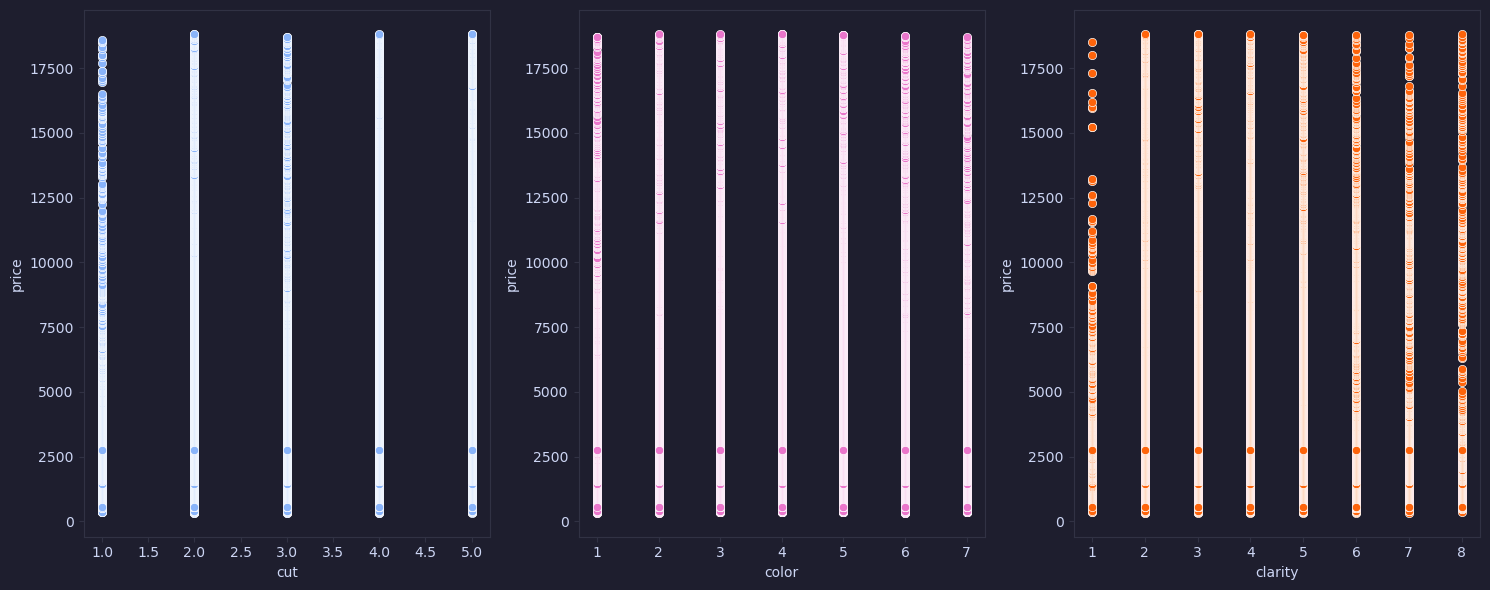

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
sns.scatterplot(data=diamonds, x='cut', y='price', ax=axs[0])
sns.scatterplot(data=diamonds, x='color', y='price', color='#EA76CB', ax=axs[1])
sns.scatterplot(data=diamonds, x='clarity', y='price', color='#FE640B', ax=axs[2])
plt.tight_layout()

### Apparently... price is more of a random value given rather than a measure of the actual quality

## ML Model

### Let's review the heatmap again

In [31]:
price = diamonds.pop('price')
diamonds.insert(0,'price',price)

<AxesSubplot: >

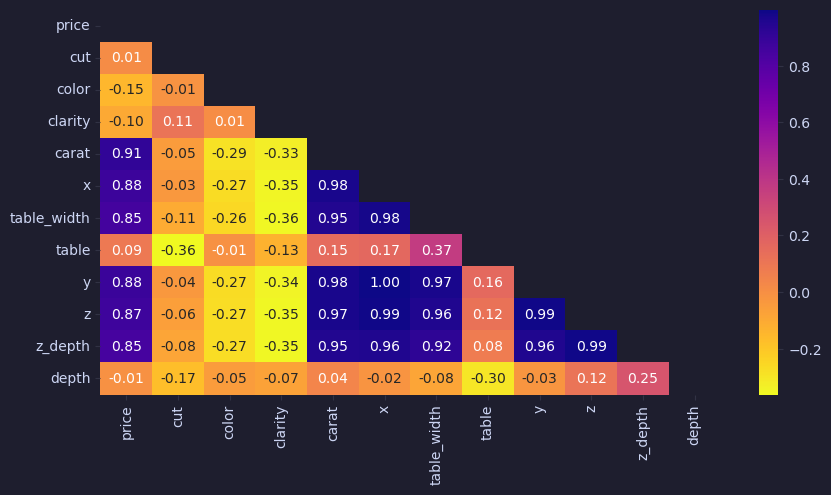

In [32]:
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(diamonds.corr()))
sns.heatmap(diamonds.corr(), annot=True, fmt='0.2f', annot_kws={'size':10}, mask=mask, cmap='plasma_r')

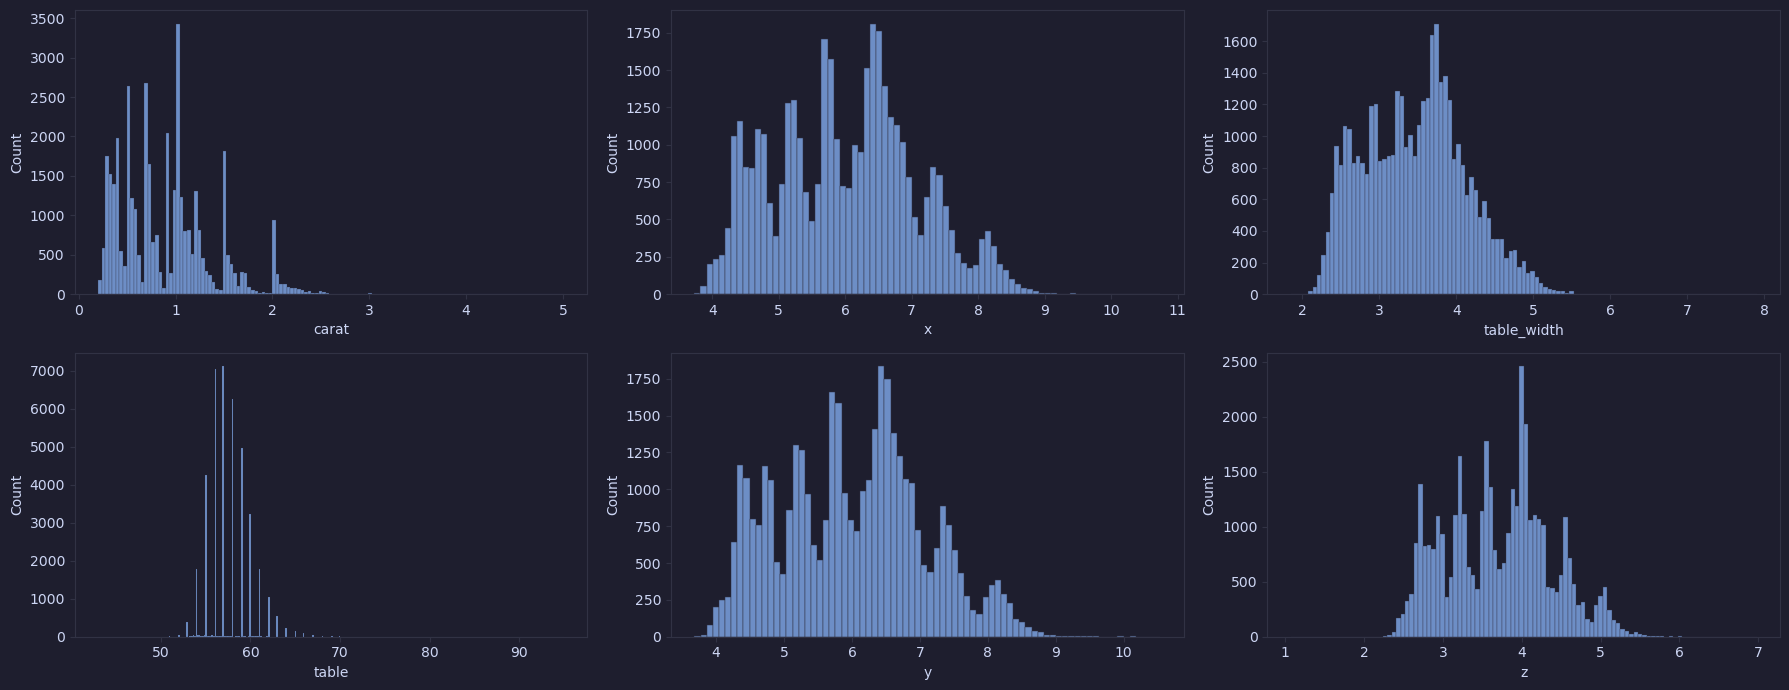

In [33]:
nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,7))
a=4
for i in range(nrows):
  for j in range(ncols):
    sns.histplot(data=diamonds, x=diamonds.columns[a], ax=axs[i,j])
    a+=1

plt.tight_layout()

### Build preprocessing layer of the pipeline

In [34]:
cut_map_r = {v:k for k,v in cut_map.items()}
color_map_r = {v:k for k,v in color_map.items()}
clarity_map_r = {v:k for k,v in clarity_map.items()}

diamonds['cut'] = diamonds['cut'].map(cut_map_r)
diamonds['color'] = diamonds['color'].map(color_map_r)
diamonds['clarity'] = diamonds['clarity'].map(clarity_map_r)

diamonds.head()

price      cut color clarity  carat     x  table_width  table     y     z  \
0  326.0    Ideal     E     SI2   0.23  3.95         2.17   55.0  3.98  2.43   
1  326.0  Premium     E     SI1   0.21  3.89         2.37   61.0  3.84  2.31   
2  327.0     Good     E     VS1   0.23  4.05         2.63   65.0  4.07  2.31   
3  334.0  Premium     I     VS2   0.29  4.20         2.44   58.0  4.23  2.63   
4  335.0     Good     J     SI2   0.31  4.34         2.52   58.0  4.35  2.75   

   z_depth  depth  
0     1.49   61.5  
1     1.38   59.8  
2     1.31   56.9  
3     1.64   62.4  
4     1.74   63.3

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, QuantileTransformer, PowerTransformer, Normalizer, MinMaxScaler, MaxAbsScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

log = FunctionTransformer(func=np.log, inverse_func=np.exp, feature_names_out='one-to-one')
norm_std = Pipeline(steps=[
  ('norm', Normalizer()),
  ('std', StandardScaler())
])
ord_cut = OrdinalEncoder(categories=[['Fair', 'Very', 'Good', 'Premium', 'Ideal']])
ord_color = OrdinalEncoder(categories=[['J', 'I', 'H', 'G', 'F', 'E', 'D']])
ord_clarity = OrdinalEncoder(categories=[['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])


scaler = QuantileTransformer(output_distribution='normal')
transformer = ColumnTransformer(transformers=[
  ('quant', scaler, ['carat', 'x', 'y', 'z']),
  ('norm', norm_std, ['z_depth', 'table_width']),
  ('ord_cut', ord_cut, ['cut']),
  ('ord_color', ord_color, ['color']),
  ('ord_clarity', ord_clarity, ['clarity'])
], verbose_feature_names_out=False, remainder=StandardScaler())
num_feats_2 = pd.DataFrame(data=transformer.fit_transform(diamonds), columns=transformer.get_feature_names_out())
num_feats_2



carat         x         y         z   z_depth  table_width  cut  \
0     -2.806711 -2.696511 -2.696511 -2.654680  0.492344    -0.477701  4.0   
1     -5.199338 -3.023039 -5.199338 -3.099353 -1.763077     1.734464  3.0   
2     -2.806711 -2.325972 -2.365248 -3.099353 -3.820592     3.453652  2.0   
3     -1.976943 -2.043115 -2.053336 -1.887753  0.197778    -0.167736  3.0   
4     -1.593219 -1.674186 -1.689670 -1.358913  0.569338    -0.559817  2.0   
...         ...       ...       ...       ...       ...          ...  ...   
39731 -0.186756 -0.209787 -0.230353 -0.318969 -0.276142     0.317262  4.0   
39732 -0.186756 -0.291367 -0.245840 -0.106841  1.308355    -1.371723  2.0   
39733 -0.324254 -0.328223 -0.333524 -0.194422 -0.077747     0.116258  1.0   
39734  0.008782  0.066541  0.037646  0.013801 -0.505050     0.545603  3.0   
39735 -0.108103 -0.118204 -0.109365 -0.069056  0.838174    -0.850153  4.0   

       color  clarity     price     table     depth  
0        5.0      1.0 -1.038235 -1.120753 -0.156956  
1        5.0      2.0 -1.038235  1.490455 -1.266060  
2        5.0      4.0 -1.037997  3.231261 -3.158062  
3        1.0      3.0 -1.036331  0.184851  0.430216  
4        0.0      1.0 -1.036092  0.184851  1.017389  
...      ...      ...       ...       ...       ...  
39731    6.0      2.0 -0.459380 -0.250350 -0.613646  
39732    6.0      2.0 -0.459380 -1.120753  0.886906  
39733    6.0      2.0 -0.459380  1.055254  0.691182  
39734    2.0      1.0 -0.459380  0.184851 -0.483163  
39735    6.0      1.0 -0.459380 -1.120753  0.299734  

[39736 rows x 12 columns]

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 9.000e+00, 2.200e+01, 3.600e+01, 5.800e+01,
        1.120e+02, 1.810e+02, 2.850e+02, 5.040e+02, 7.170e+02, 9.860e+02,
        1.304e+03, 1.768e+03, 2.078e+03, 2.629e+03, 2.794e+03, 3.008e+03,
        3.223e+03, 3.235e+03, 3.242e+03, 2.801e+03, 2.656e+03, 2.096e+03,
        1.671e+03, 1.381e+03, 9.700e+02, 7.430e+02, 5.020e+02, 3.260e+02,
        1.680e+02, 9.300e+01, 6.000e+01, 3.400e+01, 2.100e+01, 1.000e+01,
        7.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([-5.19933758e+00, -4.99136408e+00, -4.78339058e+00, -4.57541707e+00,
        -4.36744357e+00, -4.15947007e+00, -3.95149656e+00, -3.74352306e+00,
        -3.53554956e+00, -3.32757605e+00, -3.11960255e+00, -2.91162905e+00,
        -2.70365554e+00, -2.49568204e+00, -2.28770854e+00, -2.07973503e+00,
        -1.87176153e+00, -1.66378803e+00, -1.45581452e+00, -1.24784102e+

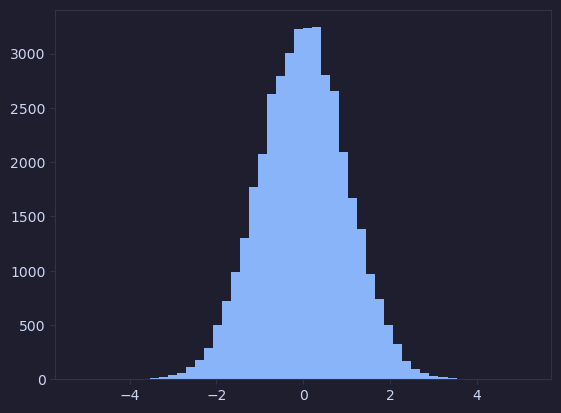

In [36]:
price = QuantileTransformer(output_distribution='normal').fit_transform(diamonds['price'].to_numpy().reshape(-1,1))
plt.hist(x=price, bins=50)

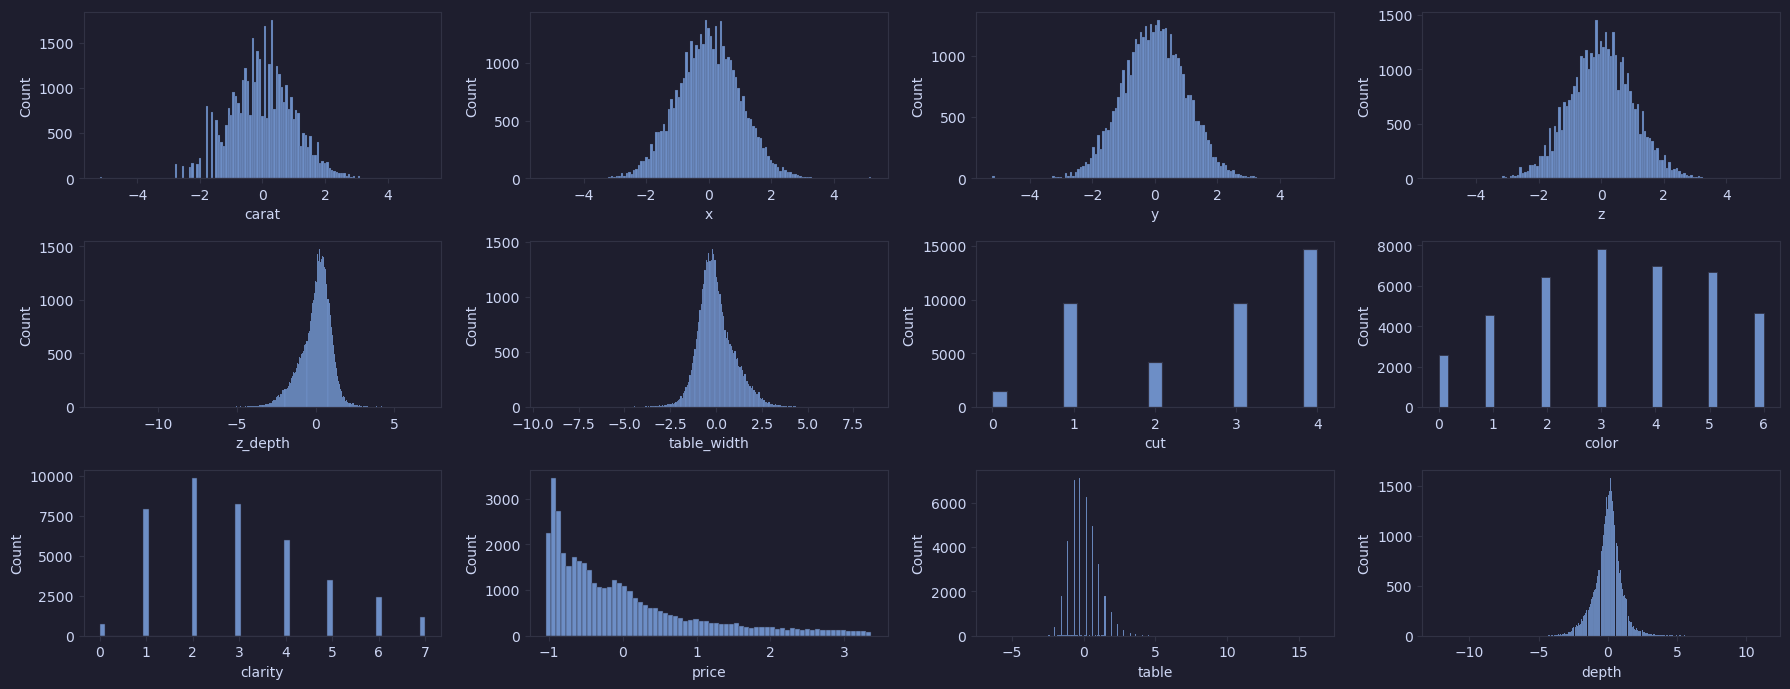

In [37]:
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,7))
a=0
for i in range(nrows):
  for j in range(ncols):
    sns.histplot(data=num_feats_2, x=num_feats_2.columns[a], ax=axs[i,j])
    a+=1

plt.tight_layout()

### Ridge model

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lars, Lasso, LassoLars, HuberRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

ridge = Pipeline(steps=[
  ('preprocessor', transformer),
  ('ridge', Ridge())
])

ridge_model = TransformedTargetRegressor(
  regressor=ridge,
  transformer=QuantileTransformer(output_distribution='normal')
)

ridge_model

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                                                   'Very',
                                                                                                                   'Good',
                                                                                                                   'Premium',
                                                                                                                   'Ideal']]),
                                                                                       ['cut']),
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
       

In [40]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

X = diamonds.drop(['price'], axis=1)
y = diamonds['price']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.85)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.65)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print('+-+-+-+-+-+-+')
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(33775, 11)
(3874, 11)
(2087, 11)
+-+-+-+-+-+-+
(33775,)
(3874,)
(2087,)


In [41]:
ridge_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                                                   'Very',
                                                                                                                   'Good',
                                                                                                                   'Premium',
                                                                                                                   'Ideal']]),
                                                                                       ['cut']),
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
       

In [56]:
def scoring(model, X, y):
  metrics = ['r2', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
  scoring = cross_validate(model, X, y, cv=10, n_jobs=-1, scoring=metrics)

  scoring_df = pd.DataFrame(scoring)
  scoring_df['test_neg_mean_absolute_percentage_error'] = scoring_df['test_neg_mean_absolute_percentage_error'].apply(lambda x: x*-1)
  scoring_df['test_neg_root_mean_squared_error'] = scoring_df['test_neg_root_mean_squared_error'].apply(lambda x: x*-1)
  return scoring_df

In [57]:
scoring(ridge_model, X_train, y_train)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  0.063455    0.009709  0.939745                                 0.143206   
1  0.062922    0.010415  0.945507                                 0.144654   
2  0.062072    0.010095  0.934148                                 0.144757   
3  0.061551    0.009635  0.940470                                 0.142248   
4  0.061096    0.009264  0.935503                                 0.144185   
5  0.062913    0.009848  0.943599                                 0.142735   
6  0.062511    0.009683  0.944406                                 0.143076   
7  0.062291    0.010051  0.936723                                 0.143251   
8  0.061042    0.009367  0.935039                                 0.145014   
9  0.063686    0.009327  0.943991                                 0.145488   

   test_neg_root_mean_squared_error  
0                       1037.893137  
1                       1011.153871  
2                       1074.070133  
3                       1014.202964  
4                       1042.611008  
5                       1008.658128  
6                       1004.547427  
7                       1056.207964  
8                       1047.852264  
9                        991.143532

In [456]:
from sklearn.metrics import PredictionErrorDisplay

def plot_prediction(model, X, y, suptitle):

  mpl.style.use('mocha')

  val_preds = model.predict(X)
  score_r2 = r2_score(y, val_preds)
  score_mean = mean_absolute_percentage_error(y, val_preds)*100
  score_mse = np.sqrt(mean_squared_error(y, val_preds))
  score_mean_abs = mean_absolute_error(y, val_preds)

  scores = {
    
    'Mean abs percent error ': f'{score_mean:0.2f} %',
    'Mean abs error ': f'{score_mean_abs:0.2f} USD',
    'Mean root sq error ': f'{score_mse:0.2f} USD',
    'R2 score of model': f'{score_r2:0.2f}'
  }

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

  display_1 = PredictionErrorDisplay.from_predictions(
    y, val_preds, kind='actual_vs_predicted', ax=axs[1], scatter_kwargs={'alpha':0.5, 'color':'#7287FD'}, line_kwargs={'color':'#D9E0EE', 'alpha':1}
  )

  axs[1].set_title('Actual vs Predicted')
  for name, score in scores.items():
    axs[0].plot([],[],' ', label=f'{name}: {score}')

  display_2 = PredictionErrorDisplay.from_predictions(
    y, val_preds, kind='residual_vs_predicted', ax=axs[0], scatter_kwargs={'alpha':0.5, 'color':'#DD7878'}, line_kwargs={'color':'#D9E0EE', 'alpha':1}
  )
  axs[0].set_title('Predicted vs Residual')
  for name, score in scores.items():
    axs[1].plot([],[],' ', label=f'{name}: {score}')

  axs[1].legend(loc='lower right')
  axs[0].legend(loc='lower left')
  suptitle_name = str(suptitle)
  plt.suptitle(t=suptitle_name, fontsize=22)
  plt.tight_layout()

  return plt.show()

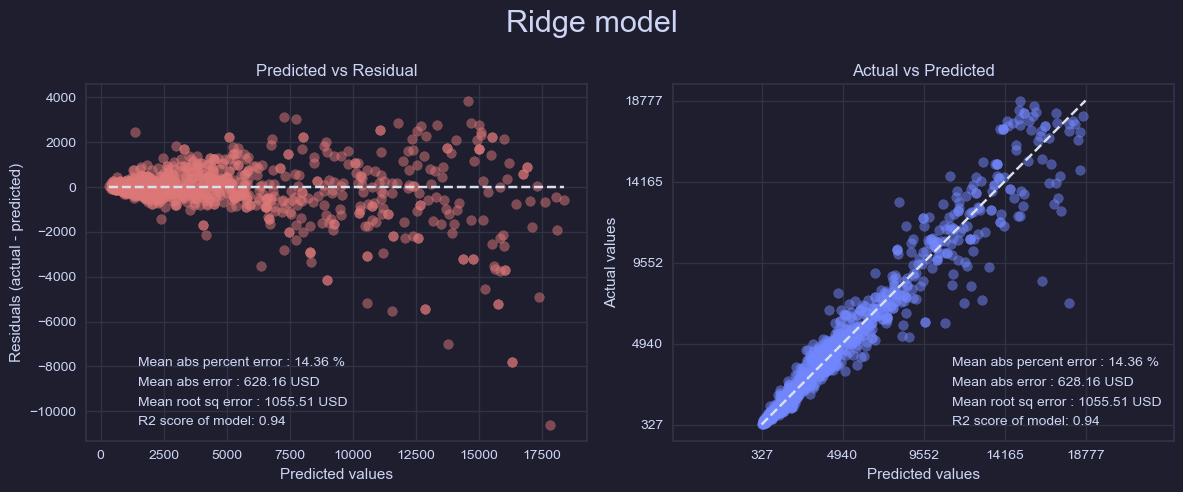

In [457]:
plot_prediction(ridge_model, X_val, y_val, 'Ridge model')

In [62]:
params = {
  'ridge__alpha':[1e-3, 1e-4, 1e-5],
  'ridge__solver':['saga', 'sparse_cg'],
  'ridge__tol':[1e-3, 1e-4, 1e-5],
  'ridge__max_iter':[50000, 100000]
}

grid_ridge = GridSearchCV(
  estimator=ridge,
  param_grid=params,
  scoring='r2',
  n_jobs=-1,
  return_train_score=True,
  cv=10
)

X_mini, x_full, y_mini, y_full = train_test_split(X, y, train_size=0.3)

grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('quant',
                                                                         QuantileTransformer(output_distribution='normal'),
                                                                         ['carat',
                                                                          'x',
                                                                          'y',
                                                                          'z']),
                                                                        ('norm',
                                                                         Pipeline(steps=[('norm',
                                                                                          Normalizer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['z_depth',
                                                                          'table_width']),
                                                                        ('ord_cut',
                                                                         OrdinalEncoder(categories=[['Fair',
                                                                                                     'V...
                                                                        ('ord_clarity',
                                                                         OrdinalEncoder(categories=[['I1',
                                                                                                     'SI2',
                                                                                                     'SI1',
                                                                                                     'VS2',
                                                                                                     'VS1',
                                                                                                     'VVS2',
                                                                                                     'VVS1',
                                                                                                     'IF']]),
                                                                         ['clarity'])],
                                                          verbose_feature_names_out=False)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.001, 0.0001, 1e-05],
                         'ridge__max_iter': [50000, 100000],
                         'ridge__solver': ['saga', 'sparse_cg'],
                         'ridge__tol': [0.001, 0.0001, 1e-05]},
             return_train_score=True, scoring='r2')

In [63]:
def fun_plot_grid_search_results(cv_results):
    cm = sns.diverging_palette(5, 250, as_cmap=True)
    df = pd.DataFrame(cv_results)
    df_formatted = pd.concat([df['params'].apply(pd.Series), df[['mean_train_score', 'mean_test_score', 'rank_test_score']]], axis=1).sort_values(by='rank_test_score')
    df_formatted = df_formatted.head(25)
    df_formatted = df_formatted.style.background_gradient(cmap=cm, subset=['mean_train_score', 'mean_test_score'])
    return df_formatted

fun_plot_grid_search_results(grid_ridge.cv_results_)

In [64]:

ridge_model_2 = TransformedTargetRegressor(
  regressor=grid_ridge.best_estimator_,
  transformer=QuantileTransformer(output_distribution='normal')
)

ridge_model_2.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
                                                                                                                   'VVS2',
                                                                                                                   'VVS1',
                                                                                                                   'IF']]),
                                                                                       ['clarity'])],
         

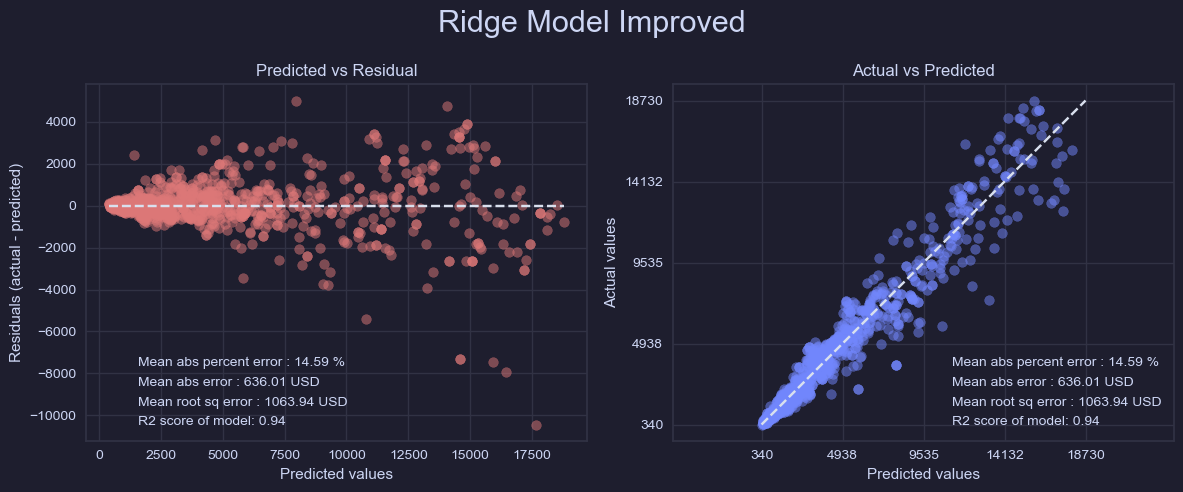

In [458]:
plot_prediction(ridge_model_2, X_val, y_val, 'Ridge Model Improved')

In [120]:
from yellowbrick.regressor import ResidualsPlot, PredictionError

def yb_plot(model, X, y, suptitle, hist=False):

  mpl.style.use('latte')

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

  if hist==False:
    vis1 = ResidualsPlot(model, hist=False, qqplot=True, ax=axs[0], train_color='#DDB6F2', test_color='#8839EF')
    vis1.fit(X_train, y_train)
    vis1.score(X, y)
    vis1.finalize()
  else:
    vis1 = ResidualsPlot(model, hist=True, qqplot=False, ax=axs[0], train_color='#DDB6F2', test_color='#8839EF')
    vis1.fit(X_train, y_train)
    vis1.score(X, y)
    vis1.finalize()

  vis2 = PredictionError(model, ax=axs[1], alpha=0.2, shared_limits=True)
  vis2.fit(X_train, y_train)
  vis2.score(X, y)
  vis2.finalize()
  
  suptitle_name = suptitle
  plt.suptitle(t=suptitle_name, size=22)
  plt.tight_layout()
  return plt.show()

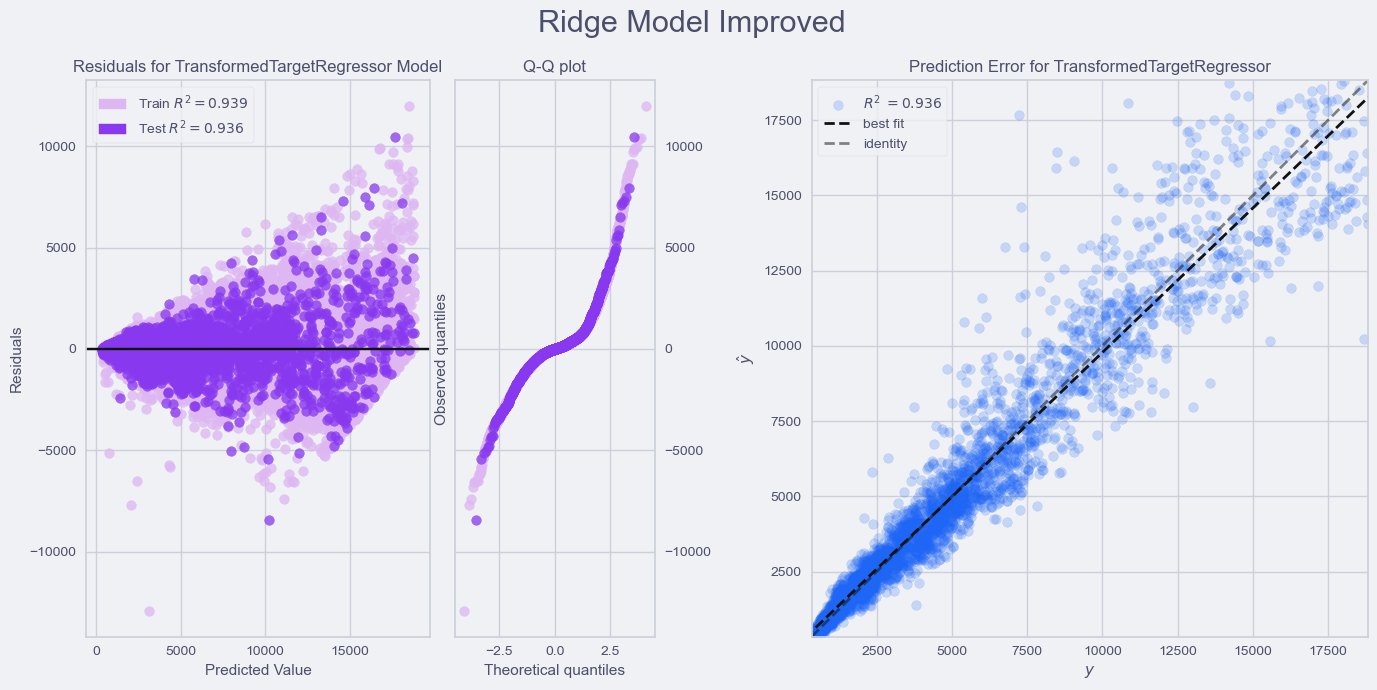

In [121]:
yb_plot(ridge_model_2, X_val, y_val, 'Ridge Model Improved')

### ElasticNet

In [68]:
elastic = Pipeline(steps=[
  ('preprocessor', transformer),
  ('elastic', ElasticNet())
])

model_elastic = TransformedTargetRegressor(
  regressor=elastic,
  transformer=QuantileTransformer(output_distribution='normal')
)

model_elastic.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                                                   'Good',
                                                                                                                   'Premium',
                                                                                                                   'Ideal']]),
                                                                                       ['cut']),
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
        

In [69]:
scoring(model_elastic, X_train, y_train)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  0.067826    0.009405  0.435825                                 0.559882   
1  0.080513    0.009852  0.424596                                 0.562748   
2  0.066883    0.009782  0.450201                                 0.571647   
3  0.066534    0.009722  0.432742                                 0.572551   
4  0.076205    0.009524  0.444437                                 0.564696   
5  0.067806    0.009734  0.436125                                 0.566679   
6  0.065411    0.009594  0.427565                                 0.583518   
7  0.069279    0.010093  0.429084                                 0.560559   
8  0.067746    0.009582  0.430255                                 0.574387   
9  0.065937    0.009571  0.457744                                 0.578342   

   test_neg_root_mean_squared_error  
0                       3175.875371  
1                       3285.735509  
2                       3103.497221  
3                       3130.737551  
4                       3059.984156  
5                       3189.287342  
6                       3223.447210  
7                       3172.591085  
8                       3103.234006  
9                       3083.963502

In [ ]:
params_elastic = {
  'elastic__alpha':[1e-5, 1e-6, 1e-7],
  'elastic__l1_ratio':[0.1, 0.2, 0.3],
  'elastic__max_iter':[10000, 15000, 20000],
  'elastic__tol':[1e-4, 1e-5, 1e-6],
  'elastic__selection':['cyclic', 'random']
}

grid_elastic = GridSearchCV(
  estimator=elastic,
  param_grid=params_elastic,
  n_jobs=-1,
  cv=10,
  return_train_score=True
)

grid_elastic.fit(X_mini, y_mini)

In [71]:
fun_plot_grid_search_results(grid_elastic.cv_results_)

In [72]:
elastic_model_2 = TransformedTargetRegressor(
  regressor=grid_elastic.best_estimator_,
  transformer=QuantileTransformer(output_distribution='normal')
)

elastic_model_2.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
                                                                                                                   'VVS2',
                                                                                                                   'VVS1',
                                                                                                                   'IF']]),
                                                                                       ['clarity'])],
                                                                        verbose_feature_names_out=False)),
  

In [73]:
scoring(elastic_model_2, X_train, y_train)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  2.753391    0.009683  0.938899                                 0.141342   
1  3.445567    0.009626  0.942433                                 0.144230   
2  2.727032    0.010506  0.933995                                 0.143597   
3  3.434664    0.009613  0.939175                                 0.144166   
4  2.703613    0.010529  0.936111                                 0.142902   
5  3.802509    0.009972  0.943776                                 0.141931   
6  3.340594    0.010000  0.942693                                 0.145309   
7  2.500361    0.011880  0.936776                                 0.144635   
8  2.542483    0.011785  0.936885                                 0.143241   
9  2.432474    0.011066  0.943522                                 0.145894   

   test_neg_root_mean_squared_error  
0                       1045.153607  
1                       1039.279144  
2                       1075.320623  
3                       1025.171521  
4                       1037.681616  
5                       1007.080798  
6                       1019.905597  
7                       1055.770509  
8                       1032.860410  
9                        995.281410

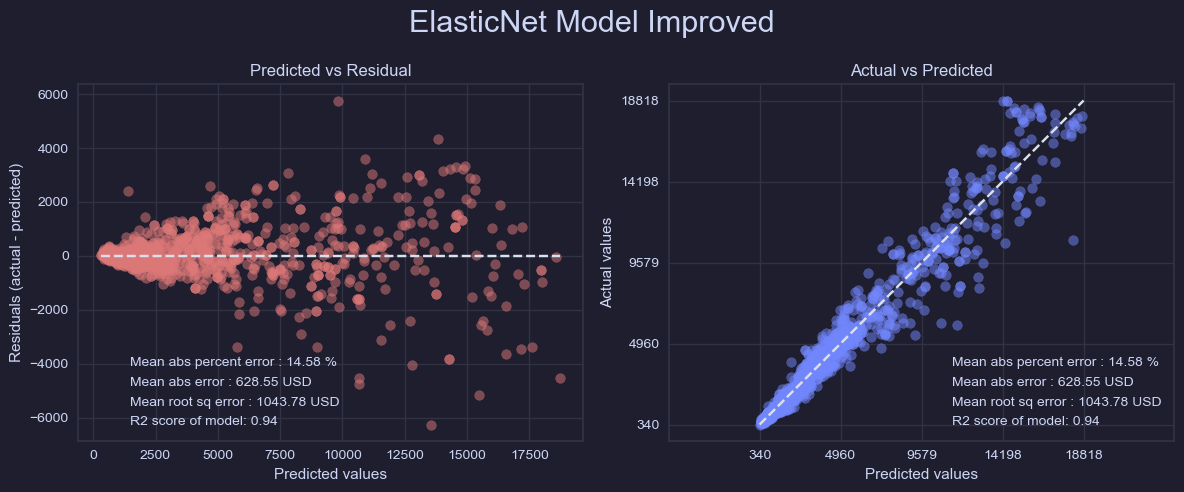

In [459]:
plot_prediction(elastic_model_2, X_val, y_val, 'ElasticNet Model Improved')

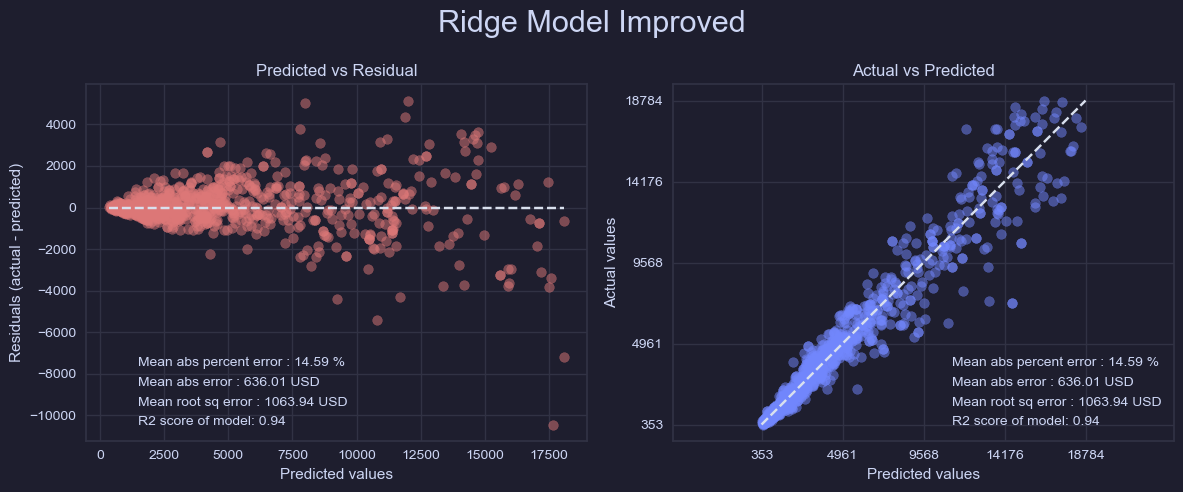

In [460]:
plot_prediction(ridge_model_2, X_val, y_val, 'Ridge Model Improved')

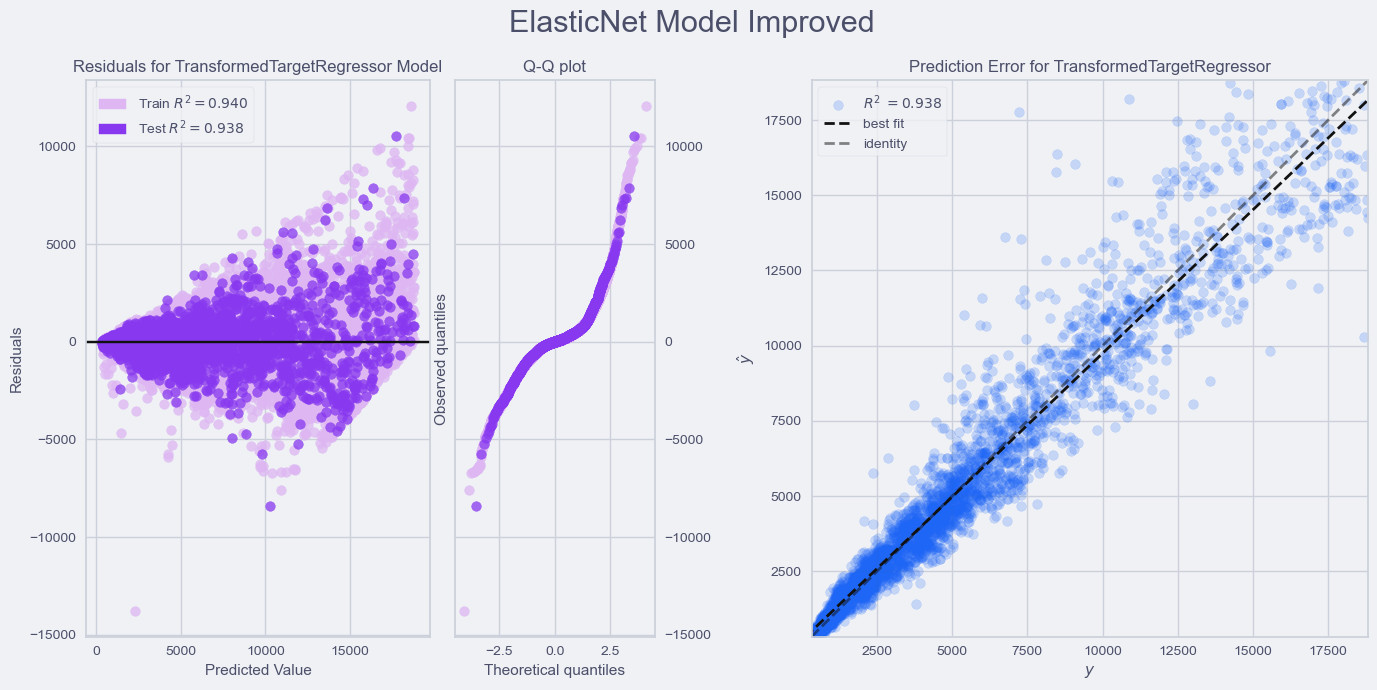

In [124]:
yb_plot(elastic_model_2, X_val, y_val, 'ElasticNet Model Improved')

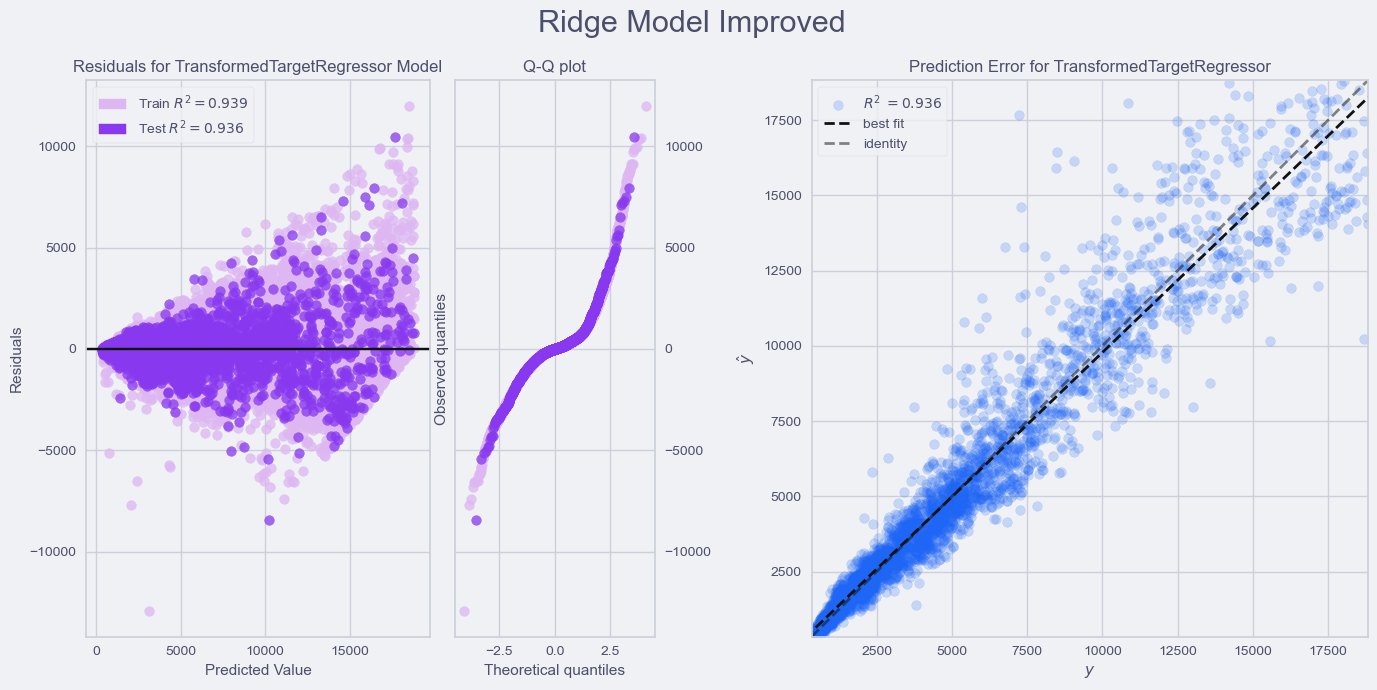

In [125]:
yb_plot(ridge_model_2, X_val, y_val, 'Ridge Model Improved')

### RandomForest

In [78]:
forest = Pipeline(steps=[
  ('preprocessor', transformer),
  ('forest', RandomForestRegressor(n_jobs=-1))
])

forest_model = TransformedTargetRegressor(
  regressor=forest,
  transformer=QuantileTransformer(output_distribution='normal')
)

forest_model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                                                   'Ideal']]),
                                                                                       ['cut']),
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
                                                                                                                   'VVS2',
                                                                                                                   'VVS1',
           

In [79]:
scoring(forest_model, X_train, y_train)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  15.542918    0.102105  0.978790                                 0.073568   
1  15.295502    0.072380  0.978184                                 0.074656   
2  15.488880    0.108562  0.980077                                 0.071326   
3  15.558748    0.114026  0.977735                                 0.074116   
4  15.614635    0.135610  0.976675                                 0.075115   
5  15.564423    0.163370  0.977141                                 0.074590   
6  15.569483    0.156859  0.978018                                 0.073570   
7  15.526765    0.086094  0.977209                                 0.075310   
8  15.524029    0.162009  0.973946                                 0.074161   
9  15.613402    0.071331  0.977973                                 0.072574   

   test_neg_root_mean_squared_error  
0                        615.780848  
1                        639.782342  
2                        590.777554  
3                        620.245912  
4                        626.994024  
5                        642.137893  
6                        631.668866  
7                        633.889782  
8                        663.611313  
9                        621.561537

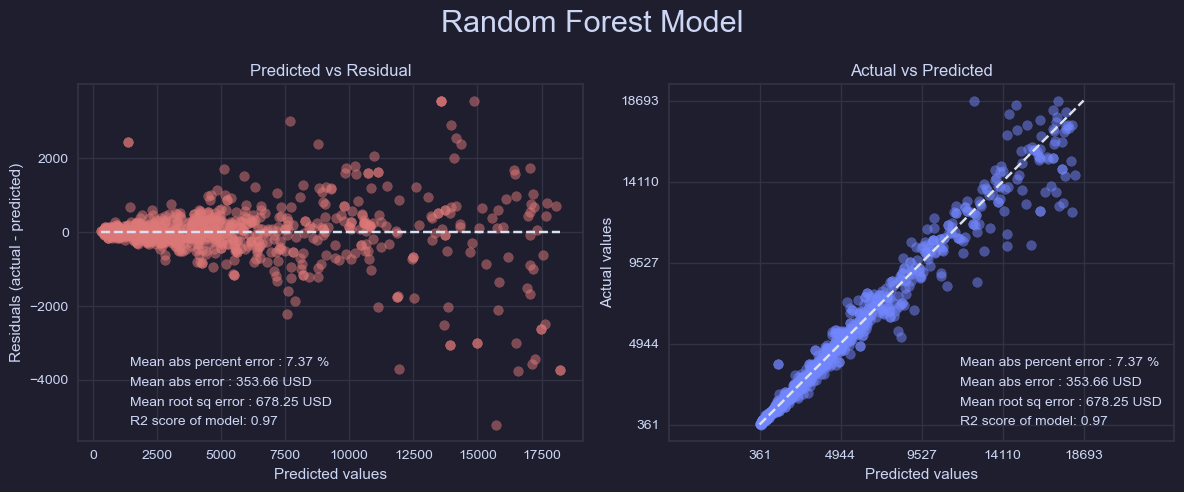

In [461]:
plot_prediction(forest_model, X_val, y_val, 'Random Forest Model')

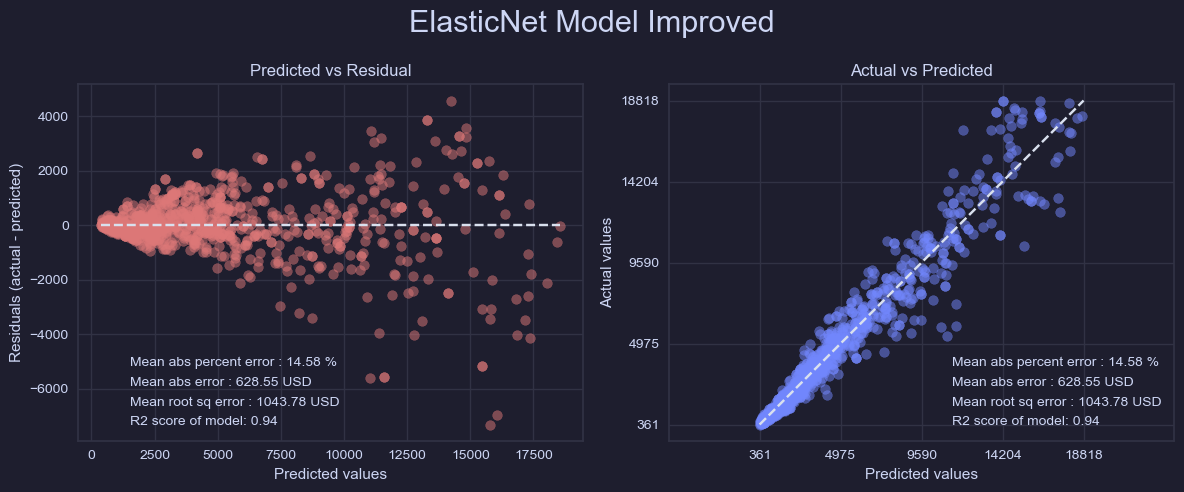

In [462]:
plot_prediction(elastic_model_2, X_val, y_val, 'ElasticNet Model Improved')

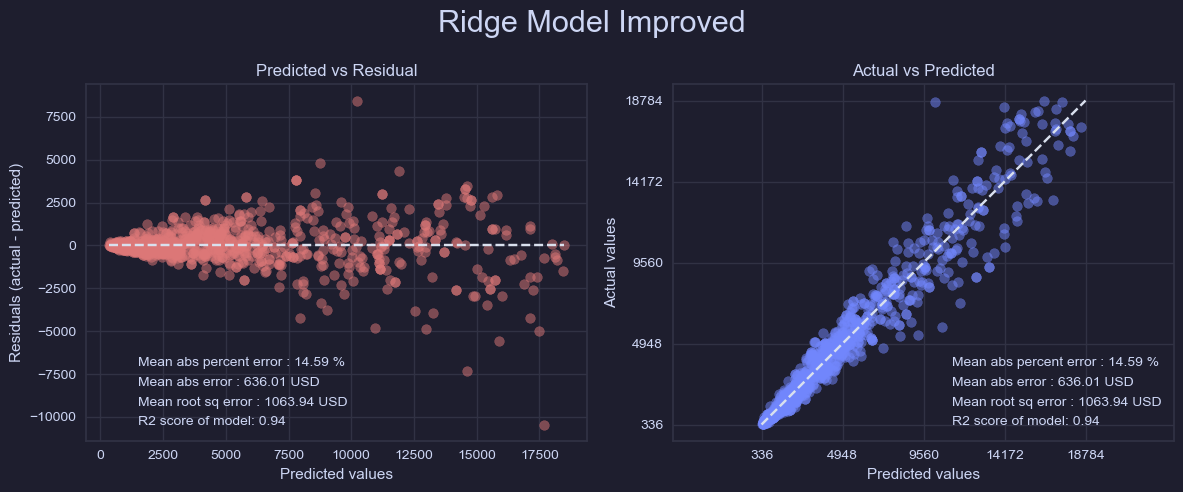

In [463]:
plot_prediction(ridge_model_2, X_val, y_val, 'Ridge Model Improved')

### XGB

In [194]:
from xgboost import XGBRegressor
xgb = Pipeline(steps=[
  ('preprocessor', transformer),
  ('xgb', XGBRegressor(n_jobs=-1))
])

model_xgb = TransformedTargetRegressor(
  regressor=xgb,
  transformer=QuantileTransformer(output_distribution='normal')
)

model_xgb.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None, ...))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [84]:
scoring(model_xgb, X_train, y_train)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  2.682069    0.017333  0.978439                                 0.073854   
1  2.674041    0.016257  0.978772                                 0.073494   
2  2.688962    0.016724  0.978422                                 0.073393   
3  2.707170    0.017348  0.976917                                 0.073612   
4  2.709666    0.016520  0.975239                                 0.075733   
5  2.773773    0.016202  0.976657                                 0.074591   
6  2.614548    0.019795  0.976750                                 0.073391   
7  2.605856    0.029210  0.978698                                 0.072672   
8  2.658943    0.016826  0.974938                                 0.073252   
9  2.730540    0.016558  0.977234                                 0.072325   

   test_neg_root_mean_squared_error  
0                        620.853249  
1                        631.099136  
2                        614.825597  
3                        631.544588  
4                        646.004869  
5                        648.901923  
6                        649.629059  
7                        612.831298  
8                        650.847219  
9                        631.909942

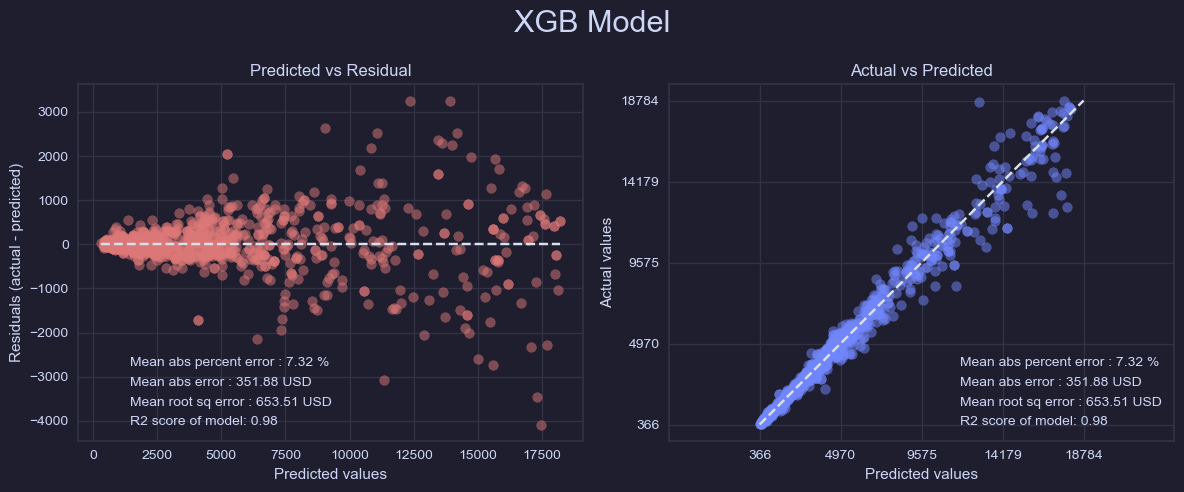

In [464]:
plot_prediction(model_xgb, X_val, y_val, 'XGB Model')

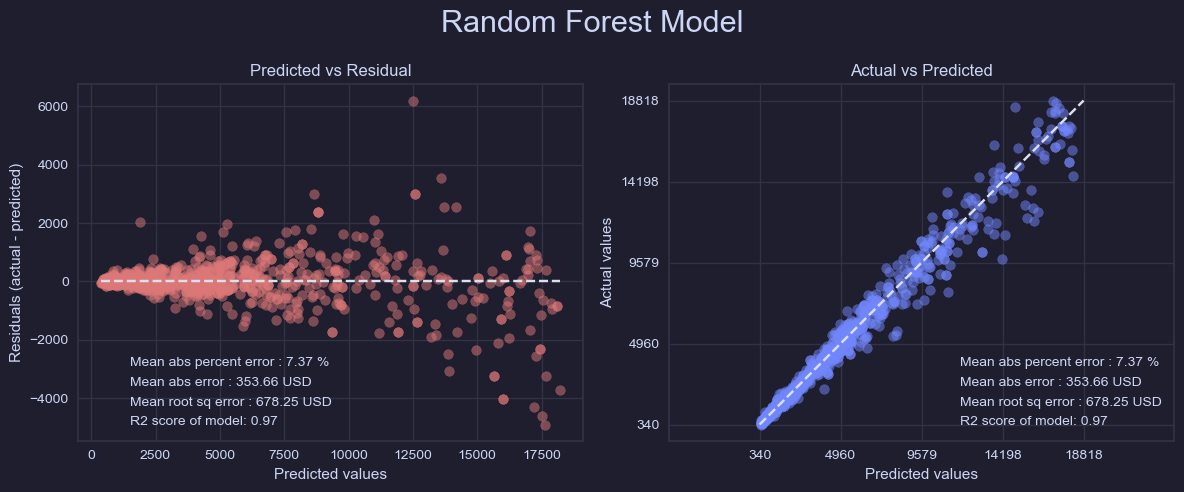

In [465]:
plot_prediction(forest_model, X_val, y_val, 'Random Forest Model')

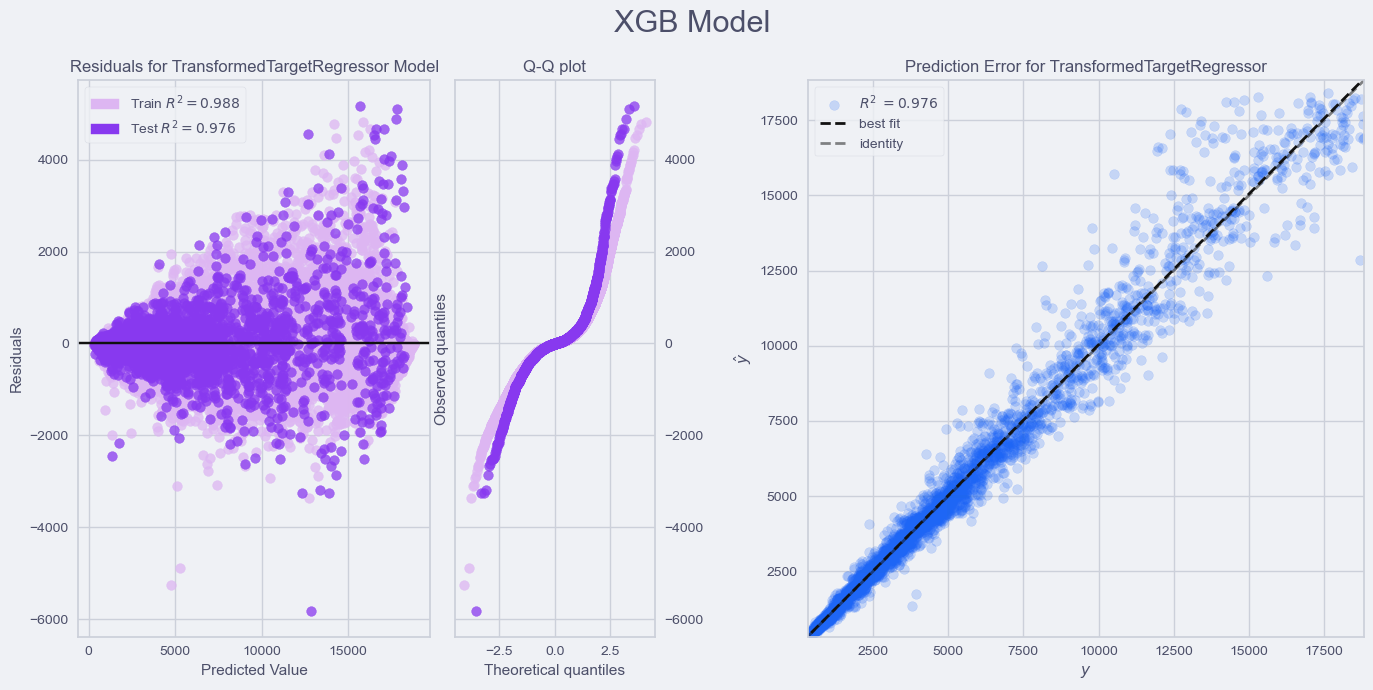

In [197]:
yb_plot(model_xgb, X_val, y_val, 'XGB Model')

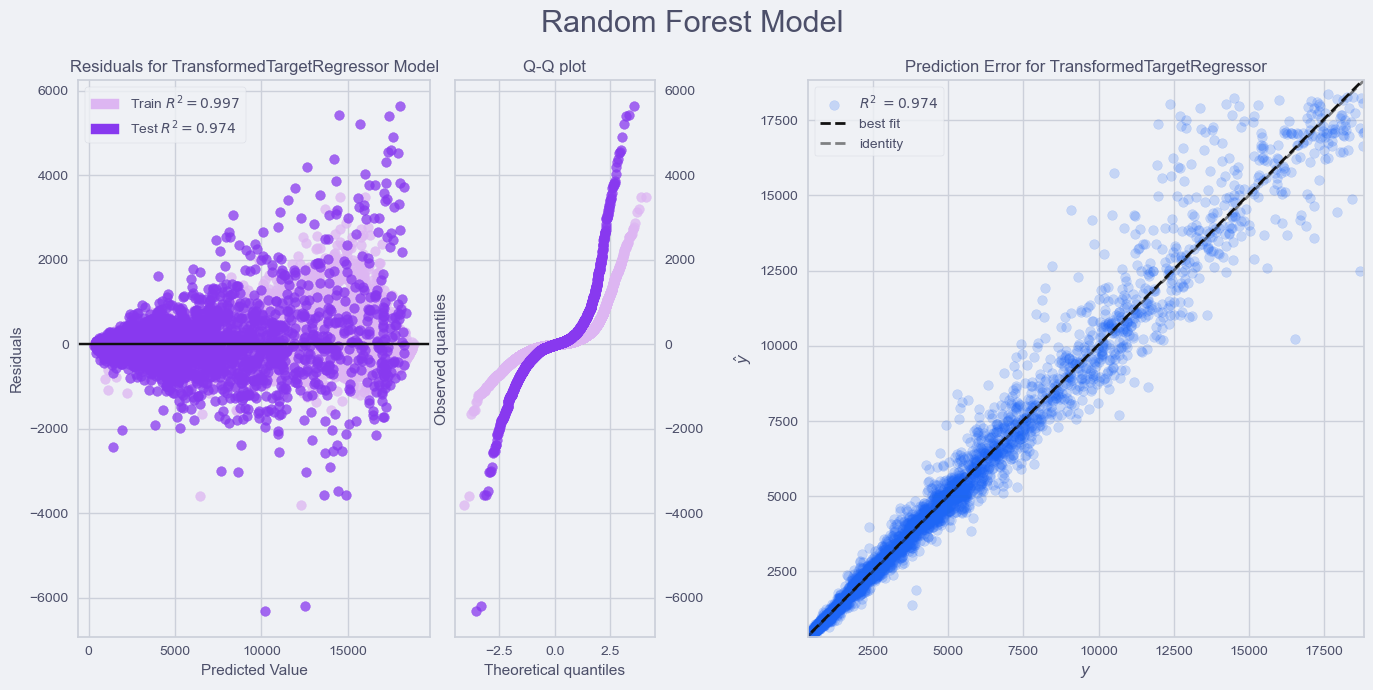

In [198]:
yb_plot(forest_model, X_val, y_val, 'Random Forest Model')

### GradientDescend

In [89]:
gbr = Pipeline(steps=[
  ('preprocessor', transformer),
  ('gbr', GradientBoostingRegressor())
])

model_gbr = TransformedTargetRegressor(
  regressor=gbr,
  transformer=QuantileTransformer(output_distribution='normal')
)

model_gbr.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                                                   'Premium',
                                                                                                                   'Ideal']]),
                                                                                       ['cut']),
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
                                                                                                                   'VVS2',
        

In [90]:
scoring(model_gbr, X_train, y_train)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  5.188585    0.014702  0.972452                                 0.085023   
1  5.108244    0.017708  0.975121                                 0.085521   
2  5.094630    0.014876  0.973238                                 0.082969   
3  5.134595    0.015817  0.974759                                 0.084240   
4  5.196125    0.016194  0.971869                                 0.086450   
5  5.102348    0.015112  0.972296                                 0.084121   
6  5.113432    0.015587  0.974476                                 0.083188   
7  5.122981    0.014793  0.973783                                 0.082271   
8  5.158189    0.015864  0.969698                                 0.084601   
9  5.211292    0.015146  0.973347                                 0.084582   

   test_neg_root_mean_squared_error  
0                        701.784424  
1                        683.224606  
2                        684.706986  
3                        660.406410  
4                        688.561217  
5                        706.922786  
6                        680.664683  
7                        679.856829  
8                        715.668764  
9                        683.723199

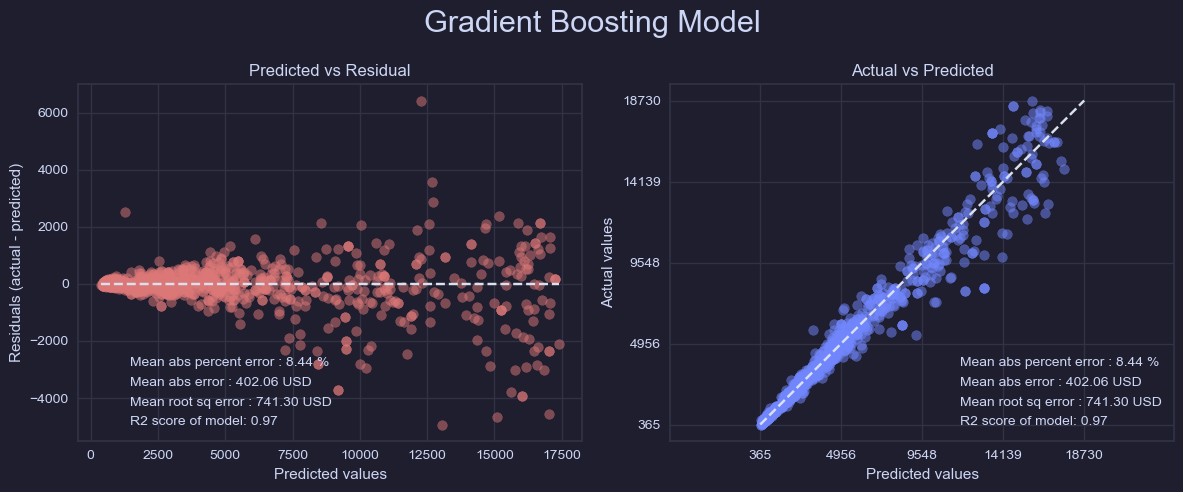

In [466]:
plot_prediction(model_gbr, X_val, y_val, 'Gradient Boosting Model')

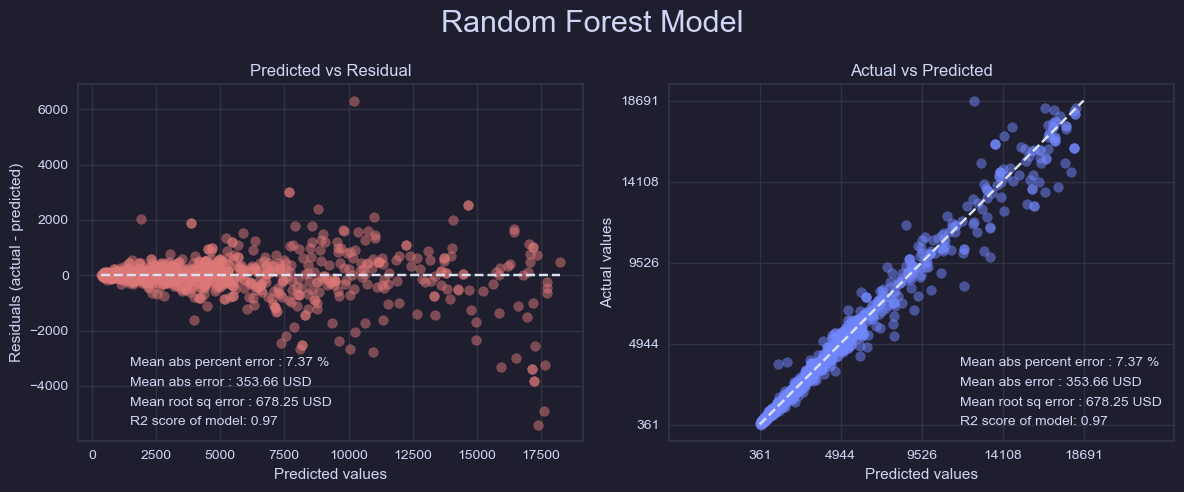

In [467]:
plot_prediction(forest_model, X_val, y_val, 'Random Forest Model')

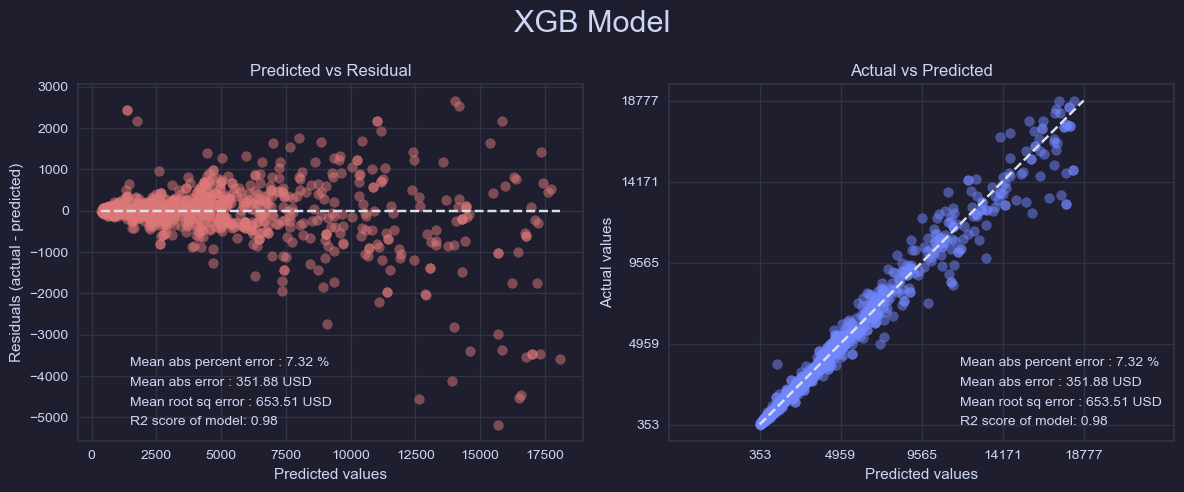

In [468]:
plot_prediction(model_xgb, X_val, y_val, 'XGB Model')

### Stack Regressor

In [202]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV, RidgeCV

estimators = [('Random Forest', forest_model), ('XGB', model_xgb)]

alphas = np.logspace(-10, 10, 100)

stack_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(alphas=alphas), n_jobs=-1, cv=10)
stack_regressor.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('Random Forest',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                                     ColumnTransformer(remainder=StandardScaler(),
                                                                                                       transformers=[('quant',
                                                                                                                      QuantileTransformer(output_distribution='normal'),
                                                                                                                      ['carat',
                                                                                                                       'x',
                                                                                                                       'y',
                                                                                                                       'z']),
                                                                                                                     ('norm',
                                                                                                                      Pipeline(steps=[('norm',
                                                                                                                                       Normalizer()),
                                                                                                                                      ('std',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['z_depth',
                                                                                                                       'tab...
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10])),
                  n_jobs=-1)

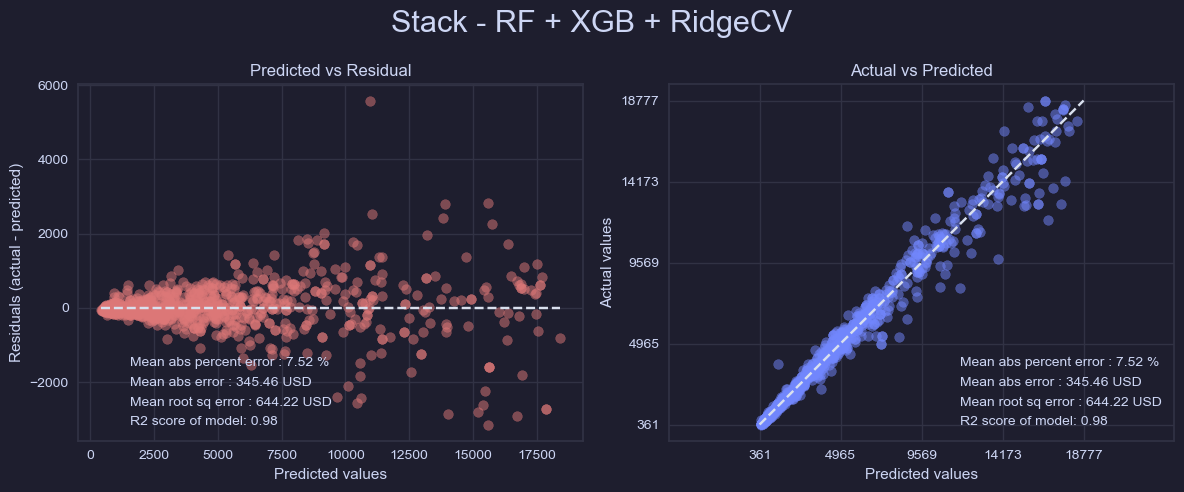

In [469]:
plot_prediction(stack_regressor, X_val, y_val, 'Stack - RF + XGB + RidgeCV')

### HistGradientBoostingRegressor

In [159]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = Pipeline(steps=[
  ('preprocessor', transformer),
  ('hgbr', HistGradientBoostingRegressor())
])

model_hgbr = TransformedTargetRegressor(
  regressor=hgbr,
  transformer=scaler
)

model_hgbr.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                                                   'Ideal']]),
                                                                                       ['cut']),
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
                                                                                                                   'VVS2',
                                                                                                                   'VVS1',
           

In [160]:
scoring(model_hgbr, X_val, y_val)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  0.415682    0.010102  0.960726                                 0.085459   
1  0.472361    0.010031  0.971536                                 0.080104   
2  0.468947    0.010299  0.971550                                 0.077773   
3  0.443847    0.013952  0.968514                                 0.082624   
4  0.363014    0.010124  0.974139                                 0.075017   
5  0.391632    0.010009  0.965637                                 0.089307   
6  0.362690    0.010097  0.969549                                 0.083938   
7  0.413251    0.009974  0.969670                                 0.084534   
8  0.422282    0.010255  0.974913                                 0.078260   
9  0.376236    0.010332  0.958720                                 0.088314   

   test_neg_root_mean_squared_error  
0                        804.191901  
1                        748.485228  
2                        711.671502  
3                        723.181630  
4                        705.866573  
5                        811.341656  
6                        679.843775  
7                        733.519312  
8                        647.824477  
9                        838.629291

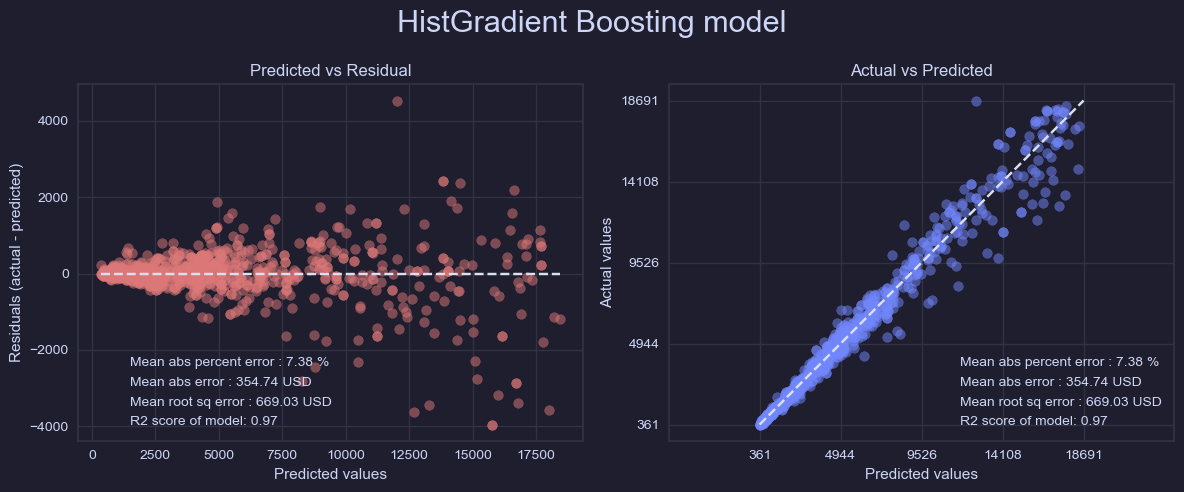

In [470]:
plot_prediction(model_hgbr, X_val, y_val, 'HistGradient Boosting model')

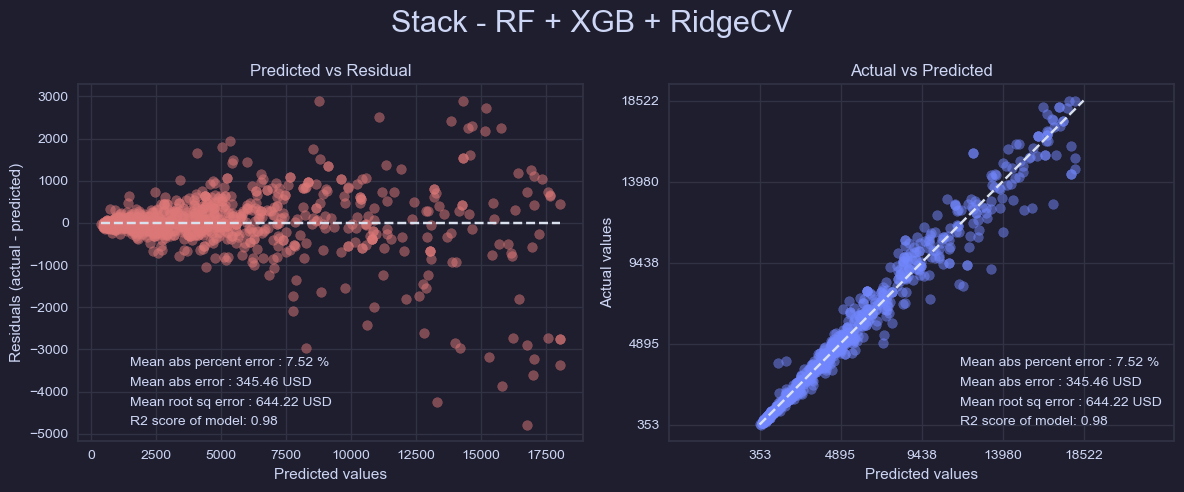

In [471]:
plot_prediction(stack_regressor, X_val, y_val, 'Stack - RF + XGB + RidgeCV')

### Second Stacking

In [205]:
estimators_2 = [('Random Forest', forest_model), ('XGB', model_xgb), ('HistGradient Boosting', model_hgbr)]

alphas = np.logspace(-10, 10, 100)

stack_regressor_2 = StackingRegressor(estimators=estimators_2, final_estimator=RidgeCV(alphas=alphas), n_jobs=-1, cv=10)
stack_regressor_2.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('Random Forest',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                                     ColumnTransformer(remainder=StandardScaler(),
                                                                                                       transformers=[('quant',
                                                                                                                      QuantileTransformer(output_distribution='normal'),
                                                                                                                      ['carat',
                                                                                                                       'x',
                                                                                                                       'y',
                                                                                                                       'z']),
                                                                                                                     ('norm',
                                                                                                                      Pipeline(steps=[('norm',
                                                                                                                                       Normalizer()),
                                                                                                                                      ('std',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['z_depth',
                                                                                                                       'tab...
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10])),
                  n_jobs=-1)

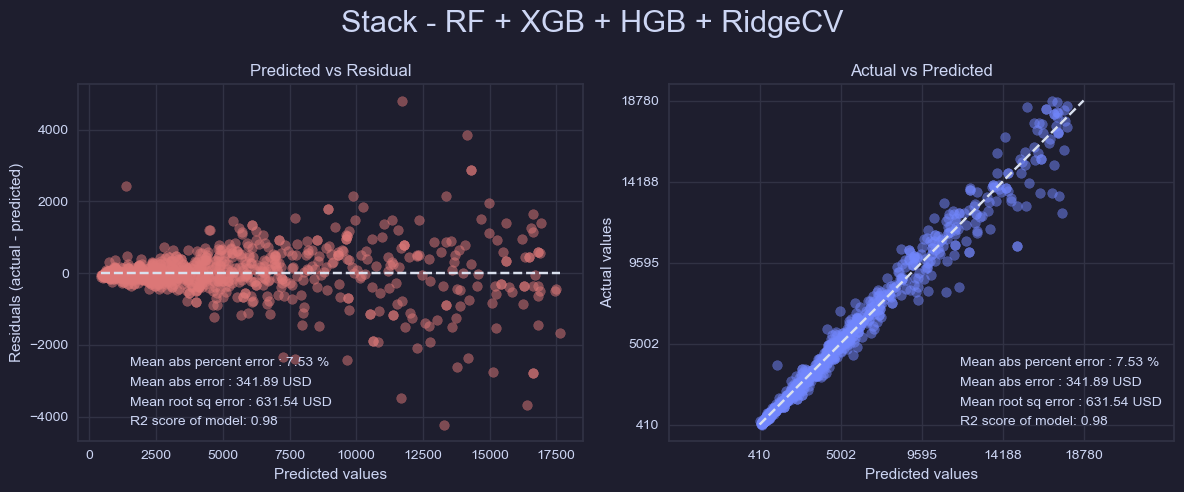

In [472]:
plot_prediction(stack_regressor_2, X_val, y_val, 'Stack - RF + XGB + HGB + RidgeCV')

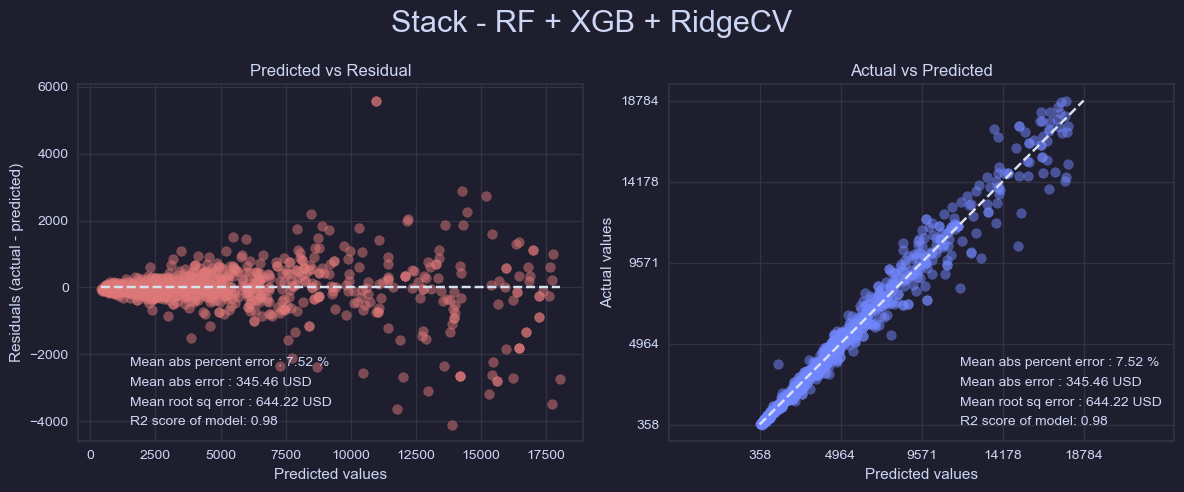

In [473]:
plot_prediction(stack_regressor, X_val, y_val, 'Stack - RF + XGB + RidgeCV')

### HuberRegressor

In [167]:
huber = Pipeline(steps=[
  ('preprocessor', transformer),
  ('huber', HuberRegressor(max_iter=10000))
])

model_huber = TransformedTargetRegressor(
  regressor=huber,
  transformer=scaler
)

model_huber.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                                                   'Ideal']]),
                                                                                       ['cut']),
                                                                                      ('ord_color',
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
                                                                                                                   'VVS2',
                                                                                                                   'VVS1',
           

In [168]:
scoring(model_huber, X_val, y_val)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  0.247040    0.007149  0.914162                                 0.142323   
1  0.301692    0.009586  0.948073                                 0.139259   
2  0.297348    0.005692  0.939311                                 0.128740   
3  0.294326    0.006741  0.944681                                 0.144668   
4  0.305503    0.005745  0.935950                                 0.131444   
5  0.275868    0.006043  0.928292                                 0.139971   
6  0.286574    0.006640  0.945157                                 0.133563   
7  0.263661    0.006739  0.950521                                 0.132451   
8  0.312049    0.006255  0.938015                                 0.137185   
9  0.278596    0.005879  0.908538                                 0.145326   

   test_neg_root_mean_squared_error  
0                       1188.900302  
1                       1010.957220  
2                       1039.421683  
3                        958.571569  
4                       1110.855962  
5                       1172.045807  
6                        912.365397  
7                        936.881950  
8                       1018.304183  
9                       1248.306364

In [169]:
params_huber = {
  'huber__epsilon':[1, 1.15, 1.30],
  'huber__alpha':[0.0001, 0.00001, 0.001],
  'huber__tol':[1e-5, 1e-6, 1e-7]
}

grid_huber = GridSearchCV(
  estimator=huber,
  param_grid=params_huber,
  scoring='r2',
  cv=10,
  n_jobs=-1,
  return_train_score=True
)

grid_huber.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('quant',
                                                                         QuantileTransformer(output_distribution='normal'),
                                                                         ['carat',
                                                                          'x',
                                                                          'y',
                                                                          'z']),
                                                                        ('norm',
                                                                         Pipeline(steps=[('norm',
                                                                                          Normalizer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['z_depth',
                                                                          'table_width']),
                                                                        ('ord_cut',
                                                                         OrdinalEncoder(categories=[['Fair',
                                                                                                     'V...
                                                                         ['color']),
                                                                        ('ord_clarity',
                                                                         OrdinalEncoder(categories=[['I1',
                                                                                                     'SI2',
                                                                                                     'SI1',
                                                                                                     'VS2',
                                                                                                     'VS1',
                                                                                                     'VVS2',
                                                                                                     'VVS1',
                                                                                                     'IF']]),
                                                                         ['clarity'])],
                                                          verbose_feature_names_out=False)),
                                       ('huber',
                                        HuberRegressor(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'huber__alpha': [0.0001, 1e-05, 0.001],
                         'huber__epsilon': [1, 1.15, 1.3],
                         'huber__tol': [1e-05, 1e-06, 1e-07]},
             return_train_score=True, scoring='r2')

In [170]:
fun_plot_grid_search_results(grid_huber.cv_results_)

In [171]:
model_huber_2 = TransformedTargetRegressor(
  regressor=grid_huber.best_estimator_,
  transformer=scaler
)

model_huber_2.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder=StandardScaler(),
                                                                        transformers=[('quant',
                                                                                       QuantileTransformer(output_distribution='normal'),
                                                                                       ['carat',
                                                                                        'x',
                                                                                        'y',
                                                                                        'z']),
                                                                                      ('norm',
                                                                                       Pipeline(steps=[('norm',
                                                                                                        Normalizer()),
                                                                                                       ('std',
                                                                                                        StandardScaler())]),
                                                                                       ['z_depth',
                                                                                        'table_width']),
                                                                                      ('ord_cut',
                                                                                       OrdinalEncoder(categories=[['...
                                                                                       OrdinalEncoder(categories=[['J',
                                                                                                                   'I',
                                                                                                                   'H',
                                                                                                                   'G',
                                                                                                                   'F',
                                                                                                                   'E',
                                                                                                                   'D']]),
                                                                                       ['color']),
                                                                                      ('ord_clarity',
                                                                                       OrdinalEncoder(categories=[['I1',
                                                                                                                   'SI2',
                                                                                                                   'SI1',
                                                                                                                   'VS2',
                                                                                                                   'VS1',
                                                                                                                   'VVS2',
                                                                                                                   'VVS1',
                                                                                                                   'IF']]),
                                                                                       ['clarity'])],
                                                                        verbose_feature_names_out=False)),
  

In [172]:
scoring(model_huber_2, X_val, y_val)

fit_time  score_time   test_r2  test_neg_mean_absolute_percentage_error  \
0  0.326810    0.005837  0.913513                                 0.141967   
1  0.308913    0.005831  0.947783                                 0.138976   
2  0.331077    0.005859  0.938925                                 0.128764   
3  0.335735    0.006008  0.944493                                 0.144406   
4  0.313999    0.005918  0.935511                                 0.131331   
5  0.335402    0.005785  0.927978                                 0.139750   
6  0.310861    0.005780  0.944996                                 0.133196   
7  0.311077    0.005442  0.950416                                 0.132025   
8  0.295823    0.005814  0.937711                                 0.137084   
9  0.297915    0.005851  0.908132                                 0.144952   

   test_neg_root_mean_squared_error  
0                       1193.386391  
1                       1013.782019  
2                       1042.726465  
3                        960.203930  
4                       1114.654833  
5                       1174.607535  
6                        913.701495  
7                        937.869511  
8                       1020.805894  
9                       1251.071329

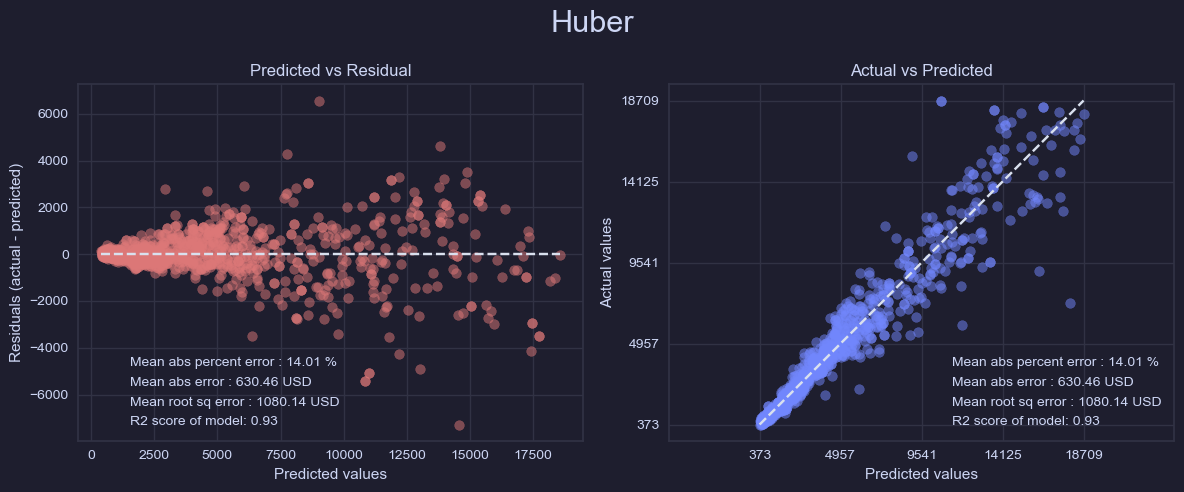

In [474]:
plot_prediction(model_huber_2, X_val, y_val, 'Huber')

### Stack test with Huber as final estimator

In [210]:
estimators_2 = [('Random Forest', forest_model), ('XGB', model_xgb), ('HistGradient Boosting', model_hgbr)]

alphas = np.logspace(-10, 10, 100)

stack_regressor_3 = StackingRegressor(estimators=estimators_2, final_estimator=HuberRegressor(alpha=0.001, epsilon=1.3, tol=0.0000001), n_jobs=-1, cv=10)
stack_regressor_3.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('Random Forest',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                                     ColumnTransformer(remainder=StandardScaler(),
                                                                                                       transformers=[('quant',
                                                                                                                      QuantileTransformer(output_distribution='normal'),
                                                                                                                      ['carat',
                                                                                                                       'x',
                                                                                                                       'y',
                                                                                                                       'z']),
                                                                                                                     ('norm',
                                                                                                                      Pipeline(steps=[('norm',
                                                                                                                                       Normalizer()),
                                                                                                                                      ('std',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['z_depth',
                                                                                                                       'tab...
                                                                                                                                                  'F',
                                                                                                                                                  'E',
                                                                                                                                                  'D']]),
                                                                                                                      ['color']),
                                                                                                                     ('ord_clarity',
                                                                                                                      OrdinalEncoder(categories=[['I1',
                                                                                                                                                  'SI2',
                                                                                                                                                  'SI1',
                                                                                                                                                  'VS2',
                                                                                                                                                  'VS1',
                                                                                                                                                  'VVS2',
                                                                                                                                                  'VVS1',
                                                                                                                                    

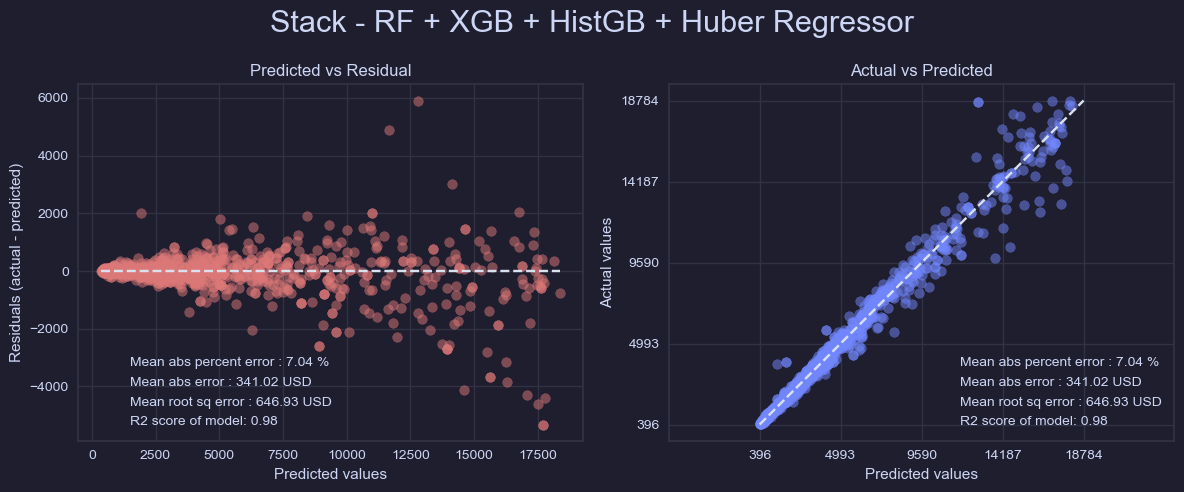

In [475]:
plot_prediction(stack_regressor_3, X_val, y_val, 'Stack - RF + XGB + HistGB + Huber Regressor')

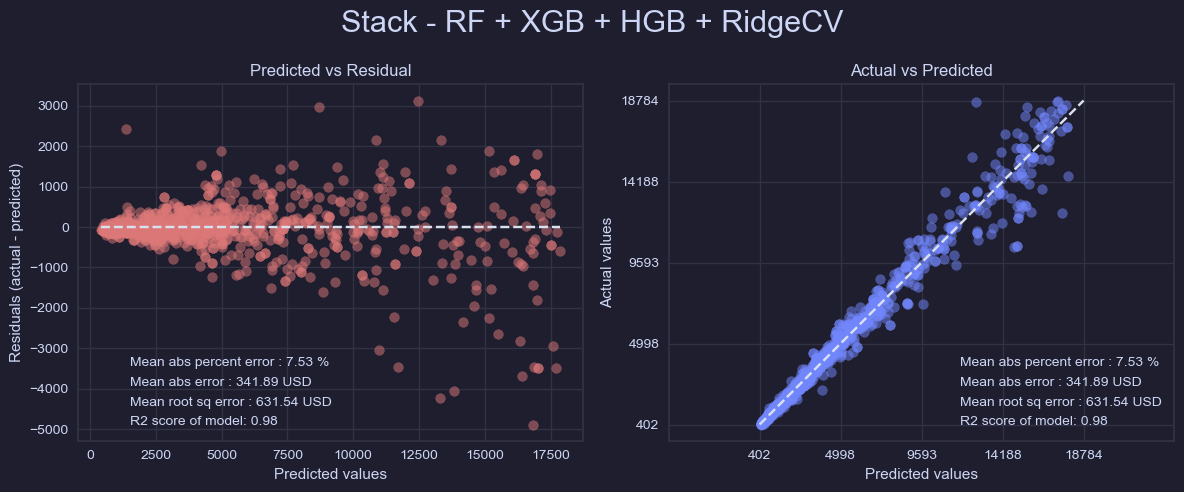

In [476]:
plot_prediction(stack_regressor_2, X_val, y_val, 'Stack - RF + XGB + HGB + RidgeCV')

### Get predictions for X_test using the best models, which in this case are the Stacked Regressors with Huber and Ridge

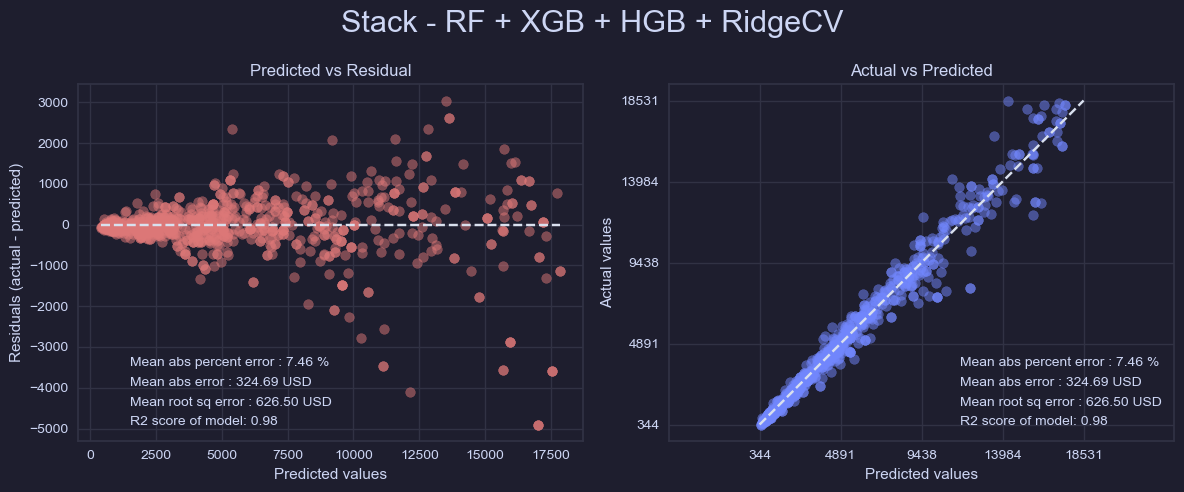

In [486]:
plot_prediction(stack_regressor_2, X_test, y_test, 'Stack - RF + XGB + HGB + RidgeCV')

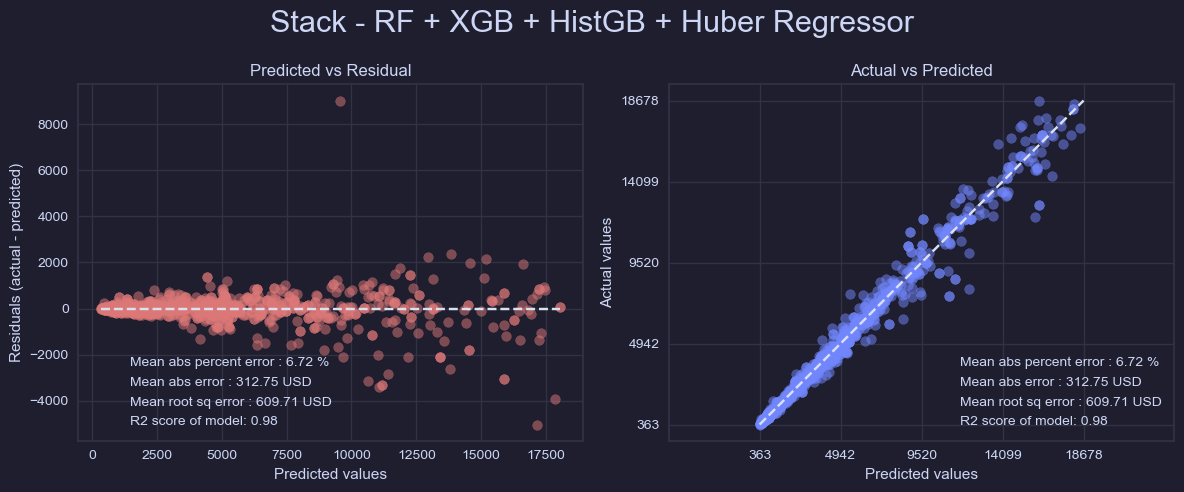

In [487]:
plot_prediction(stack_regressor_3, X_test, y_test, 'Stack - RF + XGB + HistGB + Huber Regressor')

### Best model with X_test is 'Stack - RF + XGB + HistGB + Huber Regressor'... let's get the prediction values and do some plotly graphs

In [488]:
X_test.head()

cut color clarity  carat     x  table_width  table     y     z  \
12113  Premium     J     SI1   1.25  6.90         4.00   58.0  6.88  4.27   
8013   Premium     E     SI2   1.03  6.49         3.76   58.0  6.45  3.97   
17236  Premium     H     SI1   1.27  7.04         4.08   58.0  6.99  4.22   
36599    Ideal     F    VVS1   0.32  4.44         2.49   56.0  4.45  2.73   
12672     Very     H     VS1   1.01  6.30         3.40   54.0  6.38  4.06   

       z_depth  depth  
12113     2.65   62.0  
8013      2.44   61.4  
17236     2.54   60.2  
36599     1.68   61.5  
12672     2.60   64.0

In [489]:
X_test['price_preds'] = np.round(stack_regressor_3.predict(X_test),2)
X_test.head()

cut color clarity  carat     x  table_width  table     y     z  \
12113  Premium     J     SI1   1.25  6.90         4.00   58.0  6.88  4.27   
8013   Premium     E     SI2   1.03  6.49         3.76   58.0  6.45  3.97   
17236  Premium     H     SI1   1.27  7.04         4.08   58.0  6.99  4.22   
36599    Ideal     F    VVS1   0.32  4.44         2.49   56.0  4.45  2.73   
12672     Very     H     VS1   1.01  6.30         3.40   54.0  6.38  4.06   

       z_depth  depth  price_preds  
12113     2.65   62.0      4887.85  
8013      2.44   61.4      4433.24  
17236     2.54   60.2      6595.67  
36599     1.68   61.5       989.75  
12672     2.60   64.0      5262.42

In [490]:
X_test['price'] = y_test
X_test['residuals'] = X_test['price'] - X_test['price_preds']
X_test.head()

cut color clarity  carat     x  table_width  table     y     z  \
12113  Premium     J     SI1   1.25  6.90         4.00   58.0  6.88  4.27   
8013   Premium     E     SI2   1.03  6.49         3.76   58.0  6.45  3.97   
17236  Premium     H     SI1   1.27  7.04         4.08   58.0  6.99  4.22   
36599    Ideal     F    VVS1   0.32  4.44         2.49   56.0  4.45  2.73   
12672     Very     H     VS1   1.01  6.30         3.40   54.0  6.38  4.06   

       z_depth  depth  price_preds   price  residuals  
12113     2.65   62.0      4887.85  5166.0     278.15  
8013      2.44   61.4      4433.24  4328.0    -105.24  
17236     2.54   60.2      6595.67  6892.0     296.33  
36599     1.68   61.5       989.75   947.0     -42.75  
12672     2.60   64.0      5262.42  5305.0      42.58

In [491]:
cut_map = {'Ideal':5, 'Premium':4, 'Good':3, 'Very':2, 'Fair':1}
color_map = {'D':7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1}
clarity_map = {'IF':8, 'VVS1':7, 'VVS2':6, 'VS1':5, 'VS2':4, 'SI1':3, 'SI2':2, 'I1':1}

cut_map_r = {v:k for k,v in cut_map.items()}
color_map_r = {v:k for k,v in color_map.items()}
clarity_map_r = {v:k for k,v in clarity_map.items()}

X_test['cut'] = X_test['cut'].map(cut_map)
X_test['color'] = X_test['color'].map(color_map)
X_test['clarity'] = X_test['clarity'].map(clarity_map)

X_test.head()

cut  color  clarity  carat     x  table_width  table     y     z  \
12113    4      1        3   1.25  6.90         4.00   58.0  6.88  4.27   
8013     4      6        2   1.03  6.49         3.76   58.0  6.45  3.97   
17236    4      3        3   1.27  7.04         4.08   58.0  6.99  4.22   
36599    5      5        7   0.32  4.44         2.49   56.0  4.45  2.73   
12672    2      3        5   1.01  6.30         3.40   54.0  6.38  4.06   

       z_depth  depth  price_preds   price  residuals  
12113     2.65   62.0      4887.85  5166.0     278.15  
8013      2.44   61.4      4433.24  4328.0    -105.24  
17236     2.54   60.2      6595.67  6892.0     296.33  
36599     1.68   61.5       989.75   947.0     -42.75  
12672     2.60   64.0      5262.42  5305.0      42.58

In [492]:
r2_stack = r2_score(y_test, X_test['price_preds'])
mean_perc_stack = mean_absolute_percentage_error(y_test, X_test['price_preds'])*100
mae_stack = mean_absolute_error(y_test, X_test['price_preds'])
mse_stack = np.sqrt(mean_squared_error(y_test, X_test['price_preds']))

title = 'R2: {} | MAPE: {} % | MAE: {} | MSE(Root): {}'.format(np.round(r2_stack,2), np.round(mean_perc_stack,2), np.round(mae_stack,2), np.round(mse_stack,2))
print(title)

R2: 0.98 | MAPE: 6.72 % | MAE: 312.75 | MSE(Root): 609.71


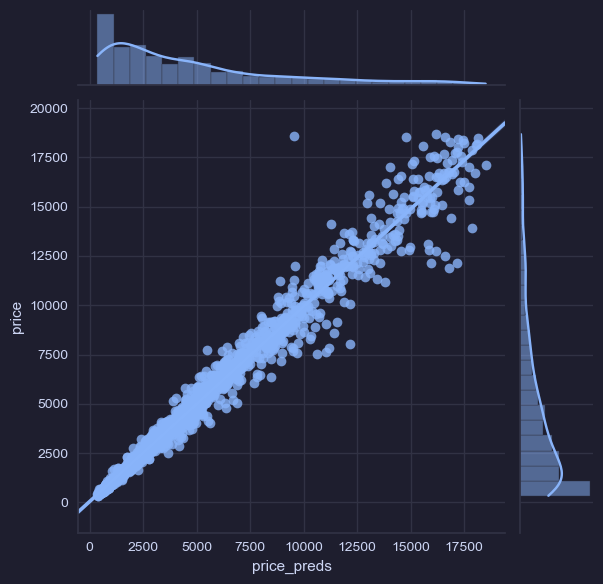

In [493]:
sns.jointplot(X_test, x='price_preds', y='price', kind='reg', truncate=False, palette='pastel')

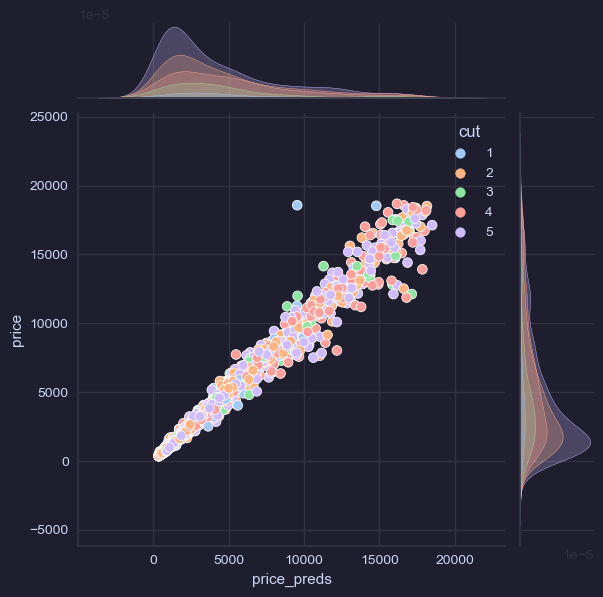

In [494]:
sns.jointplot(X_test, x='price_preds', y='price', hue='cut', palette='pastel')

In [495]:
fig = px.scatter(
  X_test, x='price_preds', y='price',
  marginal_x='violin', marginal_y='violin',
  trendline='ols', color='residuals',
  color_continuous_scale=px.colors.sequential.Jet
)


fig.update_layout(title=title, width=600, height=500, plot_bgcolor='#B5BFE2')

fig.show()

In [430]:
fig = px.scatter(
  X_test, x='price_preds', y='residuals',
  marginal_y='histogram', trendline='ols',
  color='price', color_continuous_scale=px.colors.sequential.Jet
)

fig.update_layout(title=title, width=600, height=500, plot_bgcolor='#B5BFE2')

fig.show()

In [431]:

fig = go.Figure(
  data=go.Parcoords(line=dict(color=X_test['residuals'], colorscale='Jet', showscale=True, cmin=X_test['residuals'].min(), cmax=X_test['residuals'].max()),
  dimensions=list([
    dict(
      range=[1,5],
      tickvals=[1,2,3,4,5],
      label='cut', ticktext=['Fair', 'Very', 'Good', 'Premium', 'Ideal'],
      values=X_test['cut']
      ),
    dict(
      range=[1,7],
      tickvals=[1,2,3,4,5,6,7],
      label='color', ticktext=['J', 'I', 'H', 'G', 'F', 'E', 'D'],
      values=X_test['color']
    ),
    dict(
      range=[1,8],
      tickvals=[1,2,3,4,5,6,7,8],
      label='clarity', ticktext=['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      values=X_test['clarity']
    ),
    dict(
      range=[X_test['carat'].min(), X_test['carat'].max()],
      label='carat', values=X_test['carat']
    ),
    dict(
      range=[X_test['table_width'].min(), X_test['table_width'].max()],
      label='table width', values=X_test['table_width']
    ),
    dict(
      range=[X_test['table'].min(), X_test['table'].max()],
      label='table', values=X_test['table']
    ),
    dict(
      range=[X_test['x'].min(), X_test['x'].max()],
      label='x', values=X_test['x']
    ),
    dict(
      range=[X_test['y'].min(), X_test['y'].max()],
      label='y', values=X_test['y']
    ),
    dict(
      range=[X_test['z'].min(), X_test['z'].max()],
      label='z', values=X_test['z']
    ),
    dict(
      range=[X_test['z_depth'].min(), X_test['z_depth'].max()],
      label='z depth', values=X_test['z_depth']
    ),
    dict(
      range=[X_test['depth'].min(), X_test['depth'].max()],
      label='depth', values=X_test['depth']
    ),
    dict(
      range=[X_test['price'].min(), X_test['price'].max()],
      label='price', values=X_test['price']
    ),
    dict(
      range=[X_test['price_preds'].min(), X_test['price_preds'].max()],
      label='price preds', values=X_test['price_preds']
    ),
  ])
  )
)

fig.update_layout(title=title, plot_bgcolor='#B5BFE2')

fig.show()

In [433]:
fig = go.Figure()

fig.add_trace(go.Histogram2dContour(
  x=X_test['price_preds'],
  y=X_test['price'],
  colorscale='Blues',
  reversescale=True,
  xaxis='x',
  yaxis='y'
))

fig.add_trace(go.Scatter(
  x=X_test['price_preds'],
  y=X_test['price'],
  xaxis='x',
  yaxis='y',
  mode='markers',
  marker=dict(
    color='rgba(182, 190, 209, 0.2)',
    size=3
  )
))

fig.add_trace(go.Histogram(
  y=X_test['price'],
  xaxis='x2',
  marker=dict(color='rgba(140, 169, 238, 1)')
))

fig.add_trace(go.Histogram(
  x=X_test['price_preds'],
  yaxis='y2',
  marker=dict(color='rgba(140, 169, 238, 1)')
))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False,
    title=title
)

fig.show()



In [386]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'scene'}, {'type':'scene'}]], subplot_titles=('Actual price', 'Predicted Price'))

fig.add_trace(
  go.Scatter3d(x=X_test['x'], y=X_test['y'], z=X_test['z'], mode='markers', marker=dict(size=5, color=X_test['price'], coloraxis='coloraxis')), row=1, col=1
)

fig.add_trace(
  go.Scatter3d(x=X_test['x'], y=X_test['y'], z=X_test['z'], mode='markers', marker=dict(size=5, color=X_test['price_preds'], coloraxis='coloraxis')), row=1, col=2
)

fig.update_layout(coloraxis=dict(colorscale='Turbo'), showlegend=False, width=1050, height=500, title="Diamond dimensions per price and price predicted", plot_bgcolor='#B5BFE2')

fig.show()